<a href="https://www.kaggle.com/code/godwinbentummensah/epl-standings-predictions?scriptVersionId=198222235" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [137]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eplepl/epl.csv
/kaggle/input/epl-latest-season/latest_current_season.csv
/kaggle/input/ghsoccer/gfanew.csv
/kaggle/input/ghsoccer/GFANow.csv
/kaggle/input/premier-league-standings-11-seasons-20102021/EPL Standings 2000-2022.csv
/kaggle/input/epl-current-season/current_season.csv
/kaggle/input/newepl/eeplcurrent.csv
/kaggle/input/newepl/eplcurrent.csv
/kaggle/input/eplleag/epl.csv


In [138]:
pip install kaggle


Note: you may need to restart the kernel to use updated packages.


# **Previous Season Results**

#### *Note: UEFA started allowing the 4th place team to go straight to the Champions League group stage in the 2018-19 season.

### **Get previous season results into dataframe**

In [139]:
#create dataframe
past_seasons_df = pd.read_csv('/kaggle/input/eplleag/epl.csv')

past_seasons_df.head(1000)




,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,Qualification or relegation
0,2000-01,1,Manchester United,38,24,8,6,79,31,48,80,Qualification for the Champions League first g...
1,2000-01,2,Arsenal,38,20,10,8,63,38,25,70,Qualification for the Champions League first g...
2,2000-01,3,Liverpool,38,20,9,9,71,39,32,69,Qualification for the Champions League third q...
3,2000-01,4,Leeds United,38,20,8,10,64,43,21,68,Qualification for the UEFA Cup first round[a]
4,2000-01,5,Ipswich Town,38,20,6,12,57,42,15,66,Qualification for the UEFA Cup first round[a]
...,...,...,...,...,...,...,...,...,...,...,...,...
455,2022-23,16,Nottingham Forest,38,9,11,18,38,68,-30,38,Not Applicable
456,2022-23,17,Everton,38,8,12,18,34,57,-23,36,Not Applicable
457,2022-23,18,Leicester,38,9,7,22,51,68,-17,34,Relegation to the EFL Championship
458,2022-23,19,Leeds,38,7,10,21,48,78,-30,31,Relegation to the EFL Championship


In [140]:
past_seasons_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Season                       460 non-null    object
 1   Pos                          460 non-null    int64 
 2   Team                         460 non-null    object
 3   Pld                          460 non-null    int64 
 4   W                            460 non-null    int64 
 5   D                            460 non-null    int64 
 6   L                            460 non-null    int64 
 7   GF                           460 non-null    int64 
 8   GA                           460 non-null    int64 
 9   GD                           460 non-null    int64 
 10  Pts                          460 non-null    int64 
 11  Qualification or relegation  460 non-null    object
dtypes: int64(9), object(3)
memory usage: 43.2+ KB


# **Data Quality Report**

In [141]:
data_types = pd.DataFrame(past_seasons_df.dtypes, columns=['Data Type'])
missing_data = pd.DataFrame(past_seasons_df.isnull().sum(), columns=['Missing Values'])

unique_values = pd.DataFrame(columns=['Unique Values'])
for row in list(past_seasons_df.columns.values):
    unique_values.loc[row] = [past_seasons_df[row].nunique()]

maximum_values = pd.DataFrame(columns=['Max Value'])
for row in list(past_seasons_df.columns.values):
    maximum_values.loc[row] = [past_seasons_df[row].max()]

minimum_values = pd.DataFrame(columns=['Min Value'])
for row in list(past_seasons_df.columns.values):
    minimum_values.loc[row] = [past_seasons_df[row].min()]
    
dq_report = data_types.join(missing_data).join(unique_values).join(maximum_values).join(minimum_values)
dq_report


,Data Type,Missing Values,Unique Values,Max Value,Min Value
Season,object,0,23,2022-23,2000-01
Pos,int64,0,20,20,1
Team,object,0,52,Wolves,Arsenal
Pld,int64,0,1,38,38
W,int64,0,30,32,1
D,int64,0,16,17,2
L,int64,0,30,29,0
GF,int64,0,74,106,20
GA,int64,0,64,89,15
GD,int64,0,113,79,-69


In [142]:
#top four of each season
seasons_top_four = past_seasons_df.groupby('Season').head(4)

#bottom three of each season
seasons_bottom_three = past_seasons_df.groupby('Season').tail(3)

In [143]:
seasons_top_four

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,Qualification or relegation
0,2000-01,1,Manchester United,38,24,8,6,79,31,48,80,Qualification for the Champions League first g...
1,2000-01,2,Arsenal,38,20,10,8,63,38,25,70,Qualification for the Champions League first g...
2,2000-01,3,Liverpool,38,20,9,9,71,39,32,69,Qualification for the Champions League third q...
3,2000-01,4,Leeds United,38,20,8,10,64,43,21,68,Qualification for the UEFA Cup first round[a]
20,2001-02,1,Arsenal,38,26,9,3,79,36,43,87,Qualification for the Champions League first g...
...,...,...,...,...,...,...,...,...,...,...,...,...
423,2021-22,4,Tottenham Hotspur,38,22,5,11,69,40,29,71,Qualification for the Champions League group s...
440,2022-23,1,Manchester City,38,28,5,5,94,33,61,89,Qualification for the Champions League group s...
441,2022-23,2,Arsenal,38,26,6,6,88,43,45,84,Qualification for the Champions League group s...
442,2022-23,3,Manchester United,38,23,6,9,58,43,15,75,Qualification for the Champions League group s...


In [144]:
seasons_bottom_three

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,Qualification or relegation
17,2000-01,18,Manchester City,38,8,10,20,41,65,-24,34,Relegation to the Football League First Division
18,2000-01,19,Coventry City,38,8,10,20,36,63,-27,34,Relegation to the Football League First Division
19,2000-01,20,Bradford City,38,5,11,22,30,70,-40,26,Relegation to the Football League First Division
37,2001-02,18,Ipswich Town,38,9,9,20,41,64,-23,36,Qualification for the UEFA Cup qualifying roun...
38,2001-02,19,Derby County,38,8,6,24,33,63,-30,30,Relegation to the Football League First Division
...,...,...,...,...,...,...,...,...,...,...,...,...
438,2021-22,19,Watford,38,6,5,27,34,77,-43,23,Relegation to the EFL Championship
439,2021-22,20,Norwich City,38,5,7,26,23,84,-61,22,Relegation to the EFL Championship
457,2022-23,18,Leicester,38,9,7,22,51,68,-17,34,Relegation to the EFL Championship
458,2022-23,19,Leeds,38,7,10,21,48,78,-30,31,Relegation to the EFL Championship


In [145]:
# save qualification/relegation column to new dataframe, and drop from original dataframe
seasons_results_df = past_seasons_df[['Qualification or relegation']].copy()
past_seasons_df = past_seasons_df.drop(columns=['Qualification or relegation'])


past_seasons_df

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts
0,2000-01,1,Manchester United,38,24,8,6,79,31,48,80
1,2000-01,2,Arsenal,38,20,10,8,63,38,25,70
2,2000-01,3,Liverpool,38,20,9,9,71,39,32,69
3,2000-01,4,Leeds United,38,20,8,10,64,43,21,68
4,2000-01,5,Ipswich Town,38,20,6,12,57,42,15,66
...,...,...,...,...,...,...,...,...,...,...,...
455,2022-23,16,Nottingham Forest,38,9,11,18,38,68,-30,38
456,2022-23,17,Everton,38,8,12,18,34,57,-23,36
457,2022-23,18,Leicester,38,9,7,22,51,68,-17,34
458,2022-23,19,Leeds,38,7,10,21,48,78,-30,31


In [146]:
seasons_results_df.head(20)


,Qualification or relegation
0,Qualification for the Champions League first g...
1,Qualification for the Champions League first g...
2,Qualification for the Champions League third q...
3,Qualification for the UEFA Cup first round[a]
4,Qualification for the UEFA Cup first round[a]
5,Qualification for the UEFA Cup first round[a]
6,Not Applicable
7,Qualification for the Intertoto Cup third round
8,Not Applicable
9,Not Applicable


# **Data Analysis**

### **Correlation**

<AxesSubplot:>

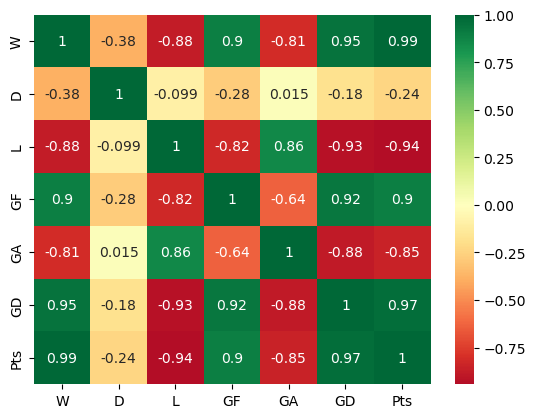

In [147]:
past_stats = past_seasons_df[['W','D','L','GF','GA','GD','Pts']].copy()
#past_stats
sns.heatmap(past_stats.corr(), annot=True, cmap='RdYlGn', center = 0)

In [148]:
plt.savefig('/kaggle/working/plot.png', format='png')


<Figure size 640x480 with 0 Axes>

All the stats clearly correlate with the amount of points a team earns.

Season Analysis

In [149]:
winners = (past_seasons_df[past_seasons_df.Pos == 1])
winners

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts
0,2000-01,1,Manchester United,38,24,8,6,79,31,48,80
20,2001-02,1,Arsenal,38,26,9,3,79,36,43,87
40,2002-03,1,Manchester United,38,25,8,5,74,34,40,83
60,2003-04,1,Arsenal,38,26,12,0,73,26,47,90
80,2004-05,1,Chelsea,38,29,8,1,72,15,57,95
100,2005-06,1,Chelsea,38,29,4,5,72,22,50,91
120,2006-07,1,Manchester United,38,28,5,5,83,27,56,89
140,2007-08,1,Manchester United,38,27,6,5,80,22,58,87
160,2008-09,1,Manchester United,38,28,6,4,68,24,44,90
180,2009-10,1,Chelsea,38,27,5,6,103,32,71,86


Text(0.5, 9.444444444444438, 'Titles')

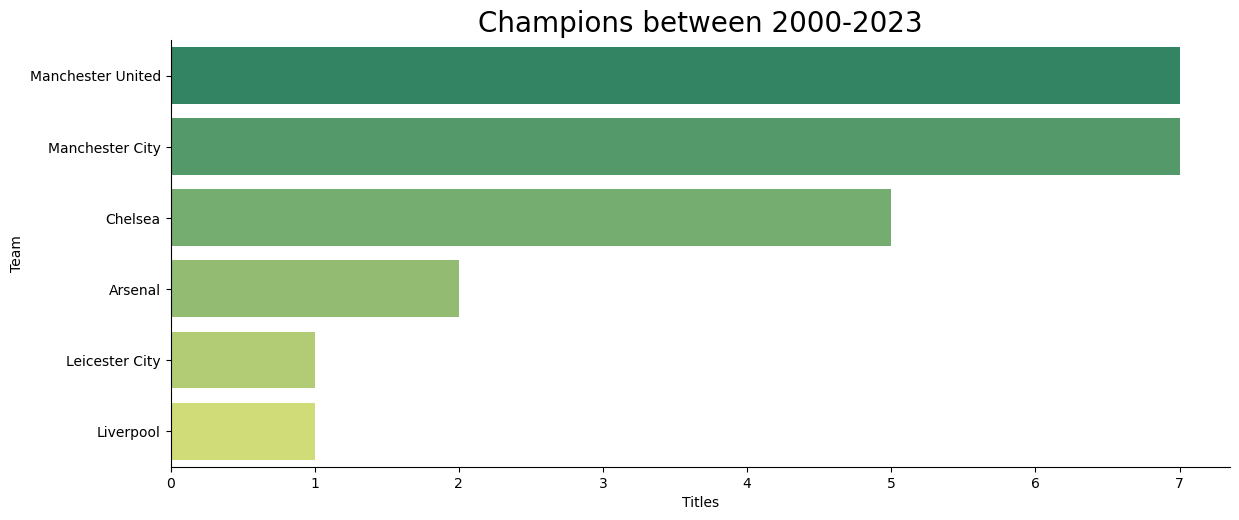

In [150]:
most_times_w = winners.Team.value_counts()
most_times_w
sns.catplot(y = 'Team', kind='count', data = winners, aspect = 2.5, order = most_times_w.index, palette = 'summer')
plt.title('Champions between 2000-2023', fontsize = 20)
plt.xlabel('Titles')

In [151]:
best_campaings = winners.sort_values('Pts',ascending=False)
best_campaings.head(1)

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts
340,2017-18,1,Manchester City,38,32,4,2,106,27,79,100


In [152]:
losers = (past_seasons_df[past_seasons_df.Pos >= 18])
relegations = losers.Team.value_counts()

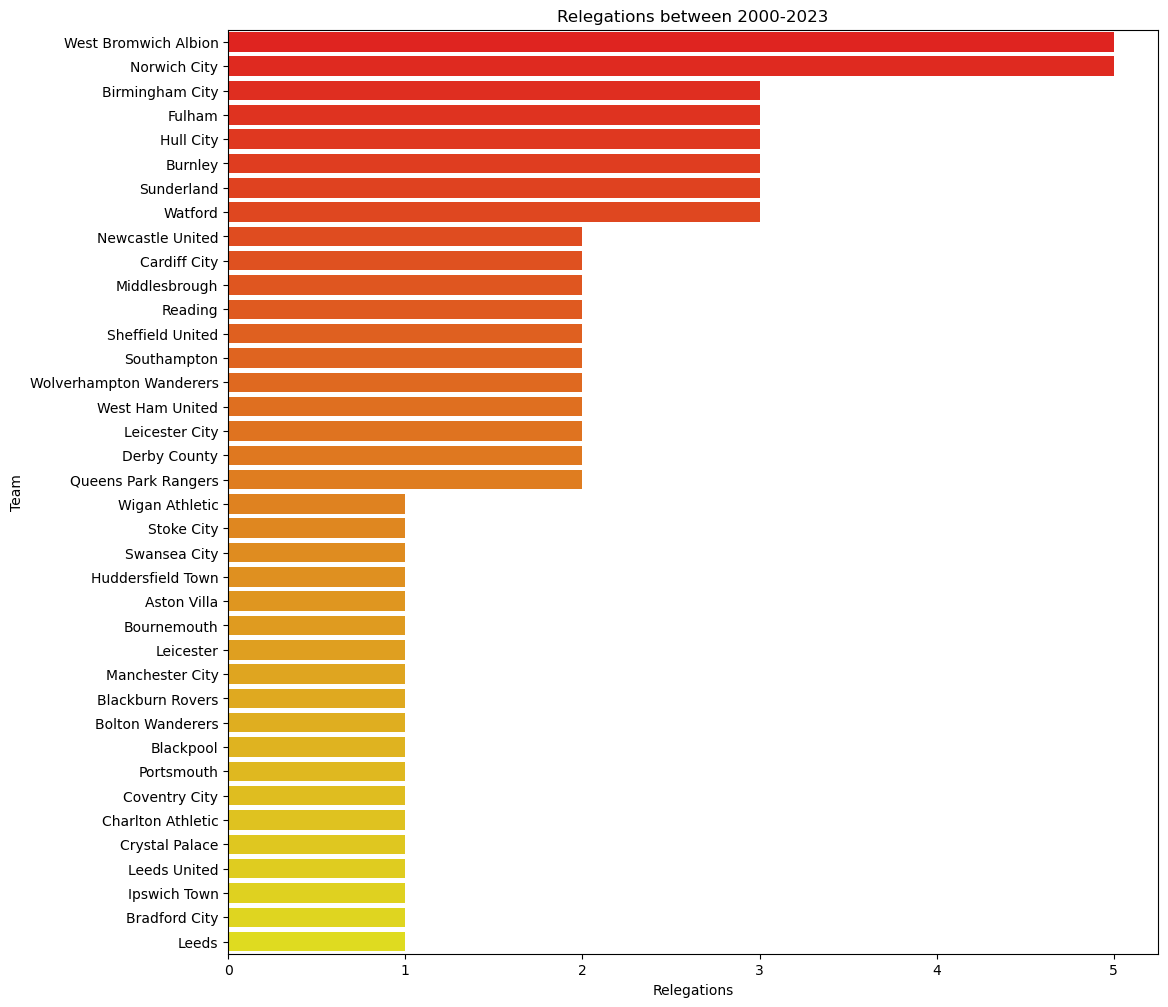

In [153]:
plt.figure(figsize=(12, 12))
sns.barplot(x=relegations, y=relegations.index, palette = 'autumn')
plt.title('Relegations between 2000-2023');
plt.xlabel('Relegations');
plt.ylabel('Team');

(0.0, 1.0)

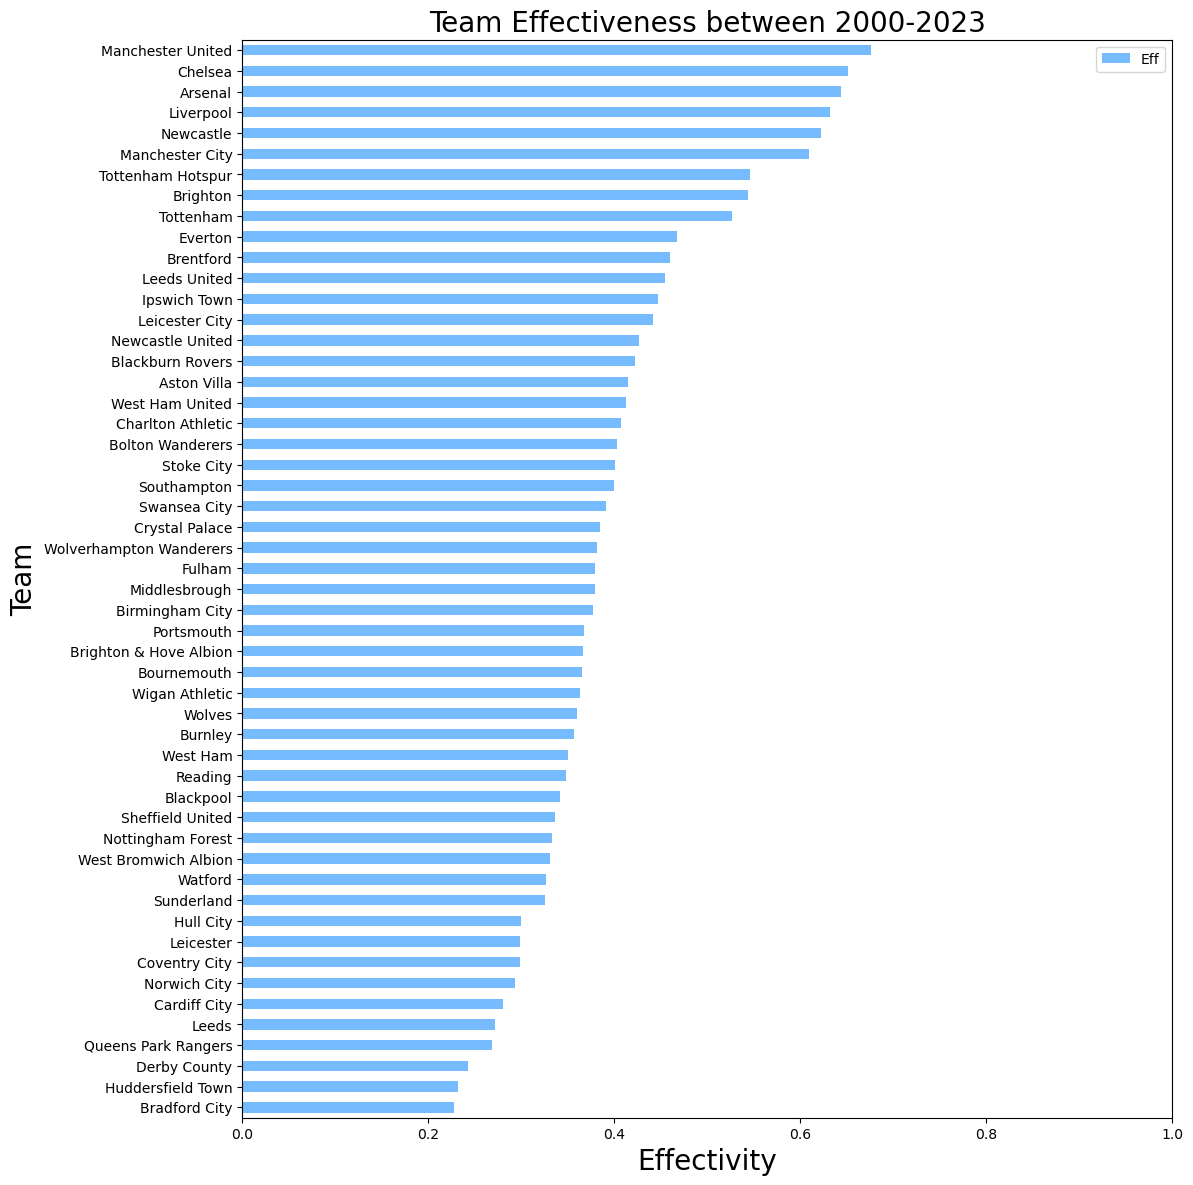

In [154]:
points_df = past_seasons_df.groupby('Team').agg({'Pts': 'sum'})
matches_df = past_seasons_df.groupby('Team').agg({'Pld':'sum'})
points_df.sort_values('Pts', ascending=False)
matches_df.sort_values('Pld', ascending=False)

effectivity_df = pd.merge(points_df, matches_df, on='Team')
effectivity_df["Total Points"] = effectivity_df['Pld']*3
effectivity_df["Eff"] = effectivity_df['Pts']/effectivity_df['Total Points']

eff_df = effectivity_df.copy()
del eff_df['Pts']
del eff_df['Pld']
del eff_df['Total Points']

eff_df = eff_df.sort_values("Eff", ascending = True)

te = eff_df.plot(kind='barh',figsize=(12,14), color='xkcd:sky blue')
plt.title('Team Effectiveness between 2000-2023',fontsize=20)
plt.ylabel('Team',fontsize=20)
plt.xlabel('Effectivity',fontsize=20);
te.set_xlim(0.0, 1)


### **Typical Stats of Top 4 and Bottom 3 Teams**

In [155]:
top_four = seasons_top_four[['W','D','L','GF','GA','GD','Pts']].copy()
bottom_three = seasons_bottom_three[['W','D','L','GF','GA','GD','Pts']].copy()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  


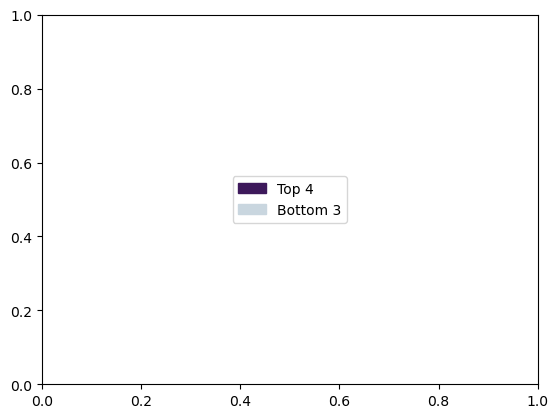

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # Import mpatches

# Visual parameters
t4_color = '#3d195b'
b3_color = '#c9d6df'
b_color = '#f7f7f7'
seaborn_color = [b3_color, t4_color]
sns.set_palette(sns.color_palette(seaborn_color))

# Creating legends
t4_legend = mpatches.Patch(color=t4_color, label='Top 4', edgecolor='black')
b3_legend = mpatches.Patch(color=b3_color, label='Bottom 3', edgecolor='black')

# Add legends to your plot later on
plt.legend(handles=[t4_legend, b3_legend], loc='center')  # Example location


#### **Wins, Draws, and Losses Distributions**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


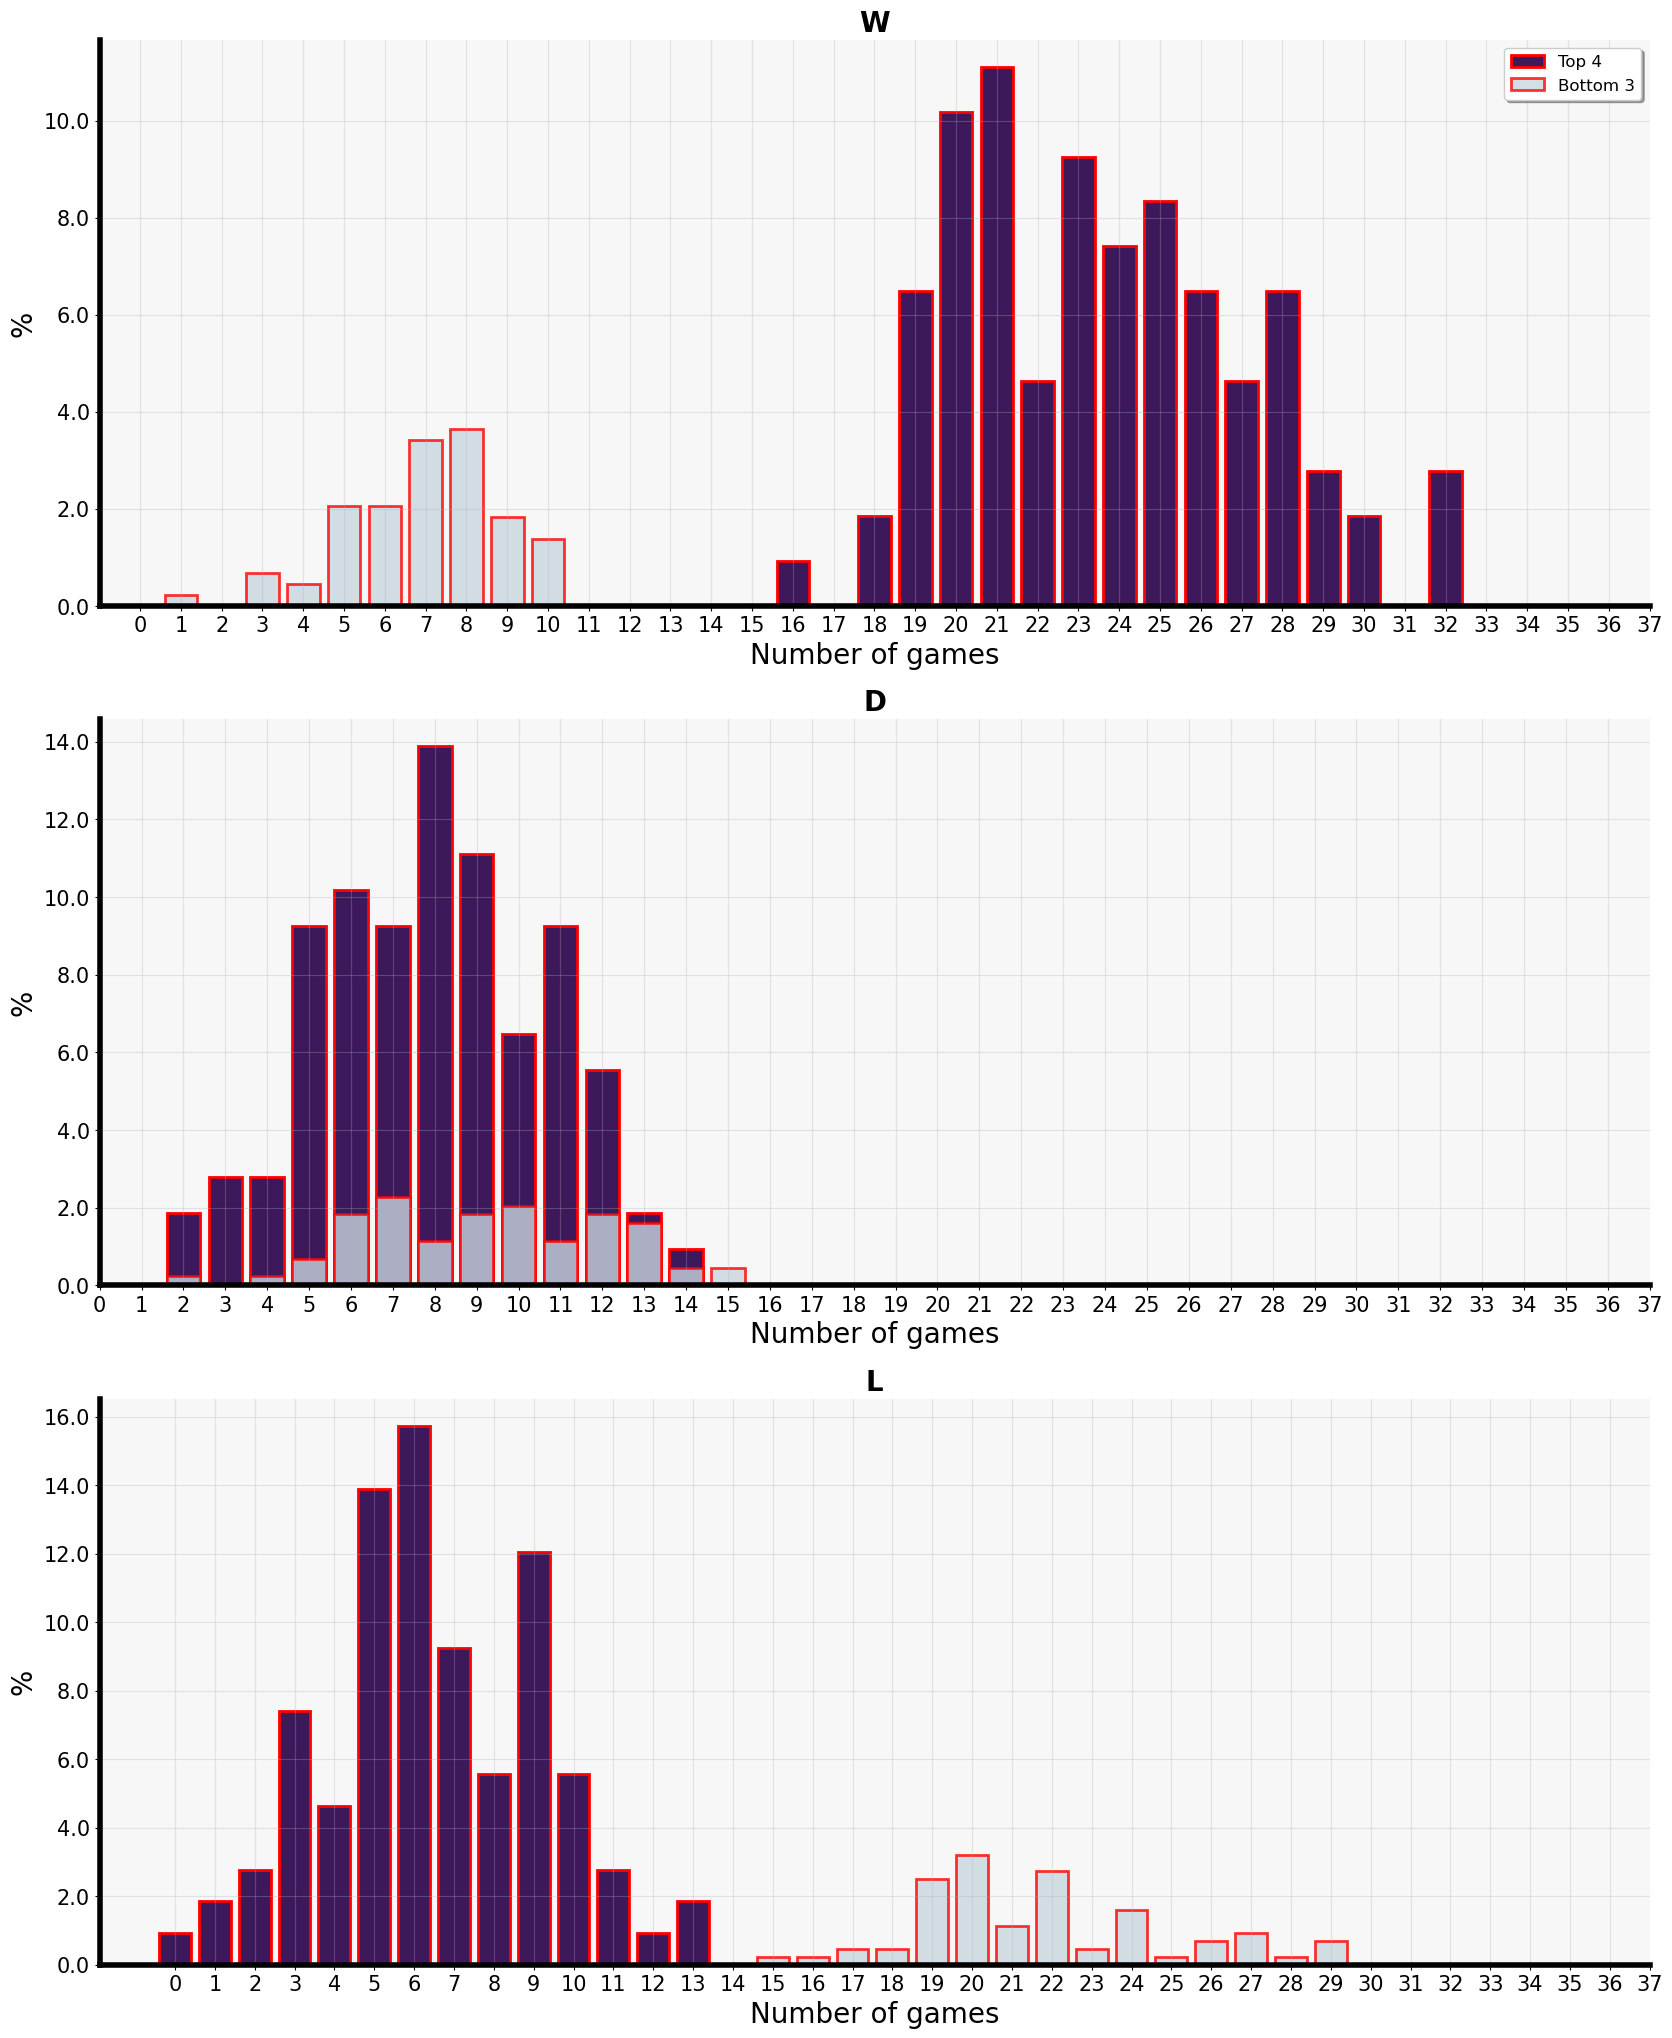

In [157]:
fig, ax = plt.subplots(3, 1, figsize=(20,25))
cols = ['W','D','L']

for i, col in enumerate(cols):
    t4_index = top_four[col].value_counts().index
    t4_values = top_four[col].value_counts().values
    b3_index = bottom_three[col].value_counts().index
    b3_values = bottom_three[col].value_counts().values
    
    ax.flatten()[i].bar(x=t4_index, height=t4_values/1.08, color=t4_color, edgecolor='red', alpha=1, linewidth=2, label='Top 4')
    ax.flatten()[i].bar(x=b3_index, height=b3_values/4.38, color=b3_color, edgecolor='red', alpha=0.8, linewidth=2, label='Bottom 3')
    
    ax.flatten()[i].grid(which='major', axis='x', zorder=0, alpha=0.3)
    ax.flatten()[i].grid(which='major', axis='y', zorder=0, alpha=0.3)
    
    ax.flatten()[i].set_xticks(np.arange(0, 38, 1))
    ax.flatten()[i].set_xticklabels(ax.flatten()[i].get_xticks(), fontsize=15)
    ax.flatten()[i].set_yticklabels(ax.flatten()[i].get_yticks(), fontsize=15)
    ax.flatten()[i].set_xlabel('Number of games', fontsize=20)
    ax.flatten()[i].set_ylabel('%', fontsize=20)
    ax.flatten()[i].set_title(col.upper(), weight='bold', fontsize=20)
    ax.flatten()[i].set_facecolor(b_color)
    
    ax.flatten()[i].spines['top'].set_visible(False)
    ax.flatten()[i].spines['right'].set_visible(False)
    ax.flatten()[i].spines['bottom'].set_linewidth(4)
    ax.flatten()[i].spines['left'].set_linewidth(4)
    
    if i == 0:
        ax.flatten()[i].legend(loc=1, shadow=True, fontsize=12)

In [158]:
plt.savefig('/kaggle/working/plot.png', format='png')


<Figure size 640x480 with 0 Axes>

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


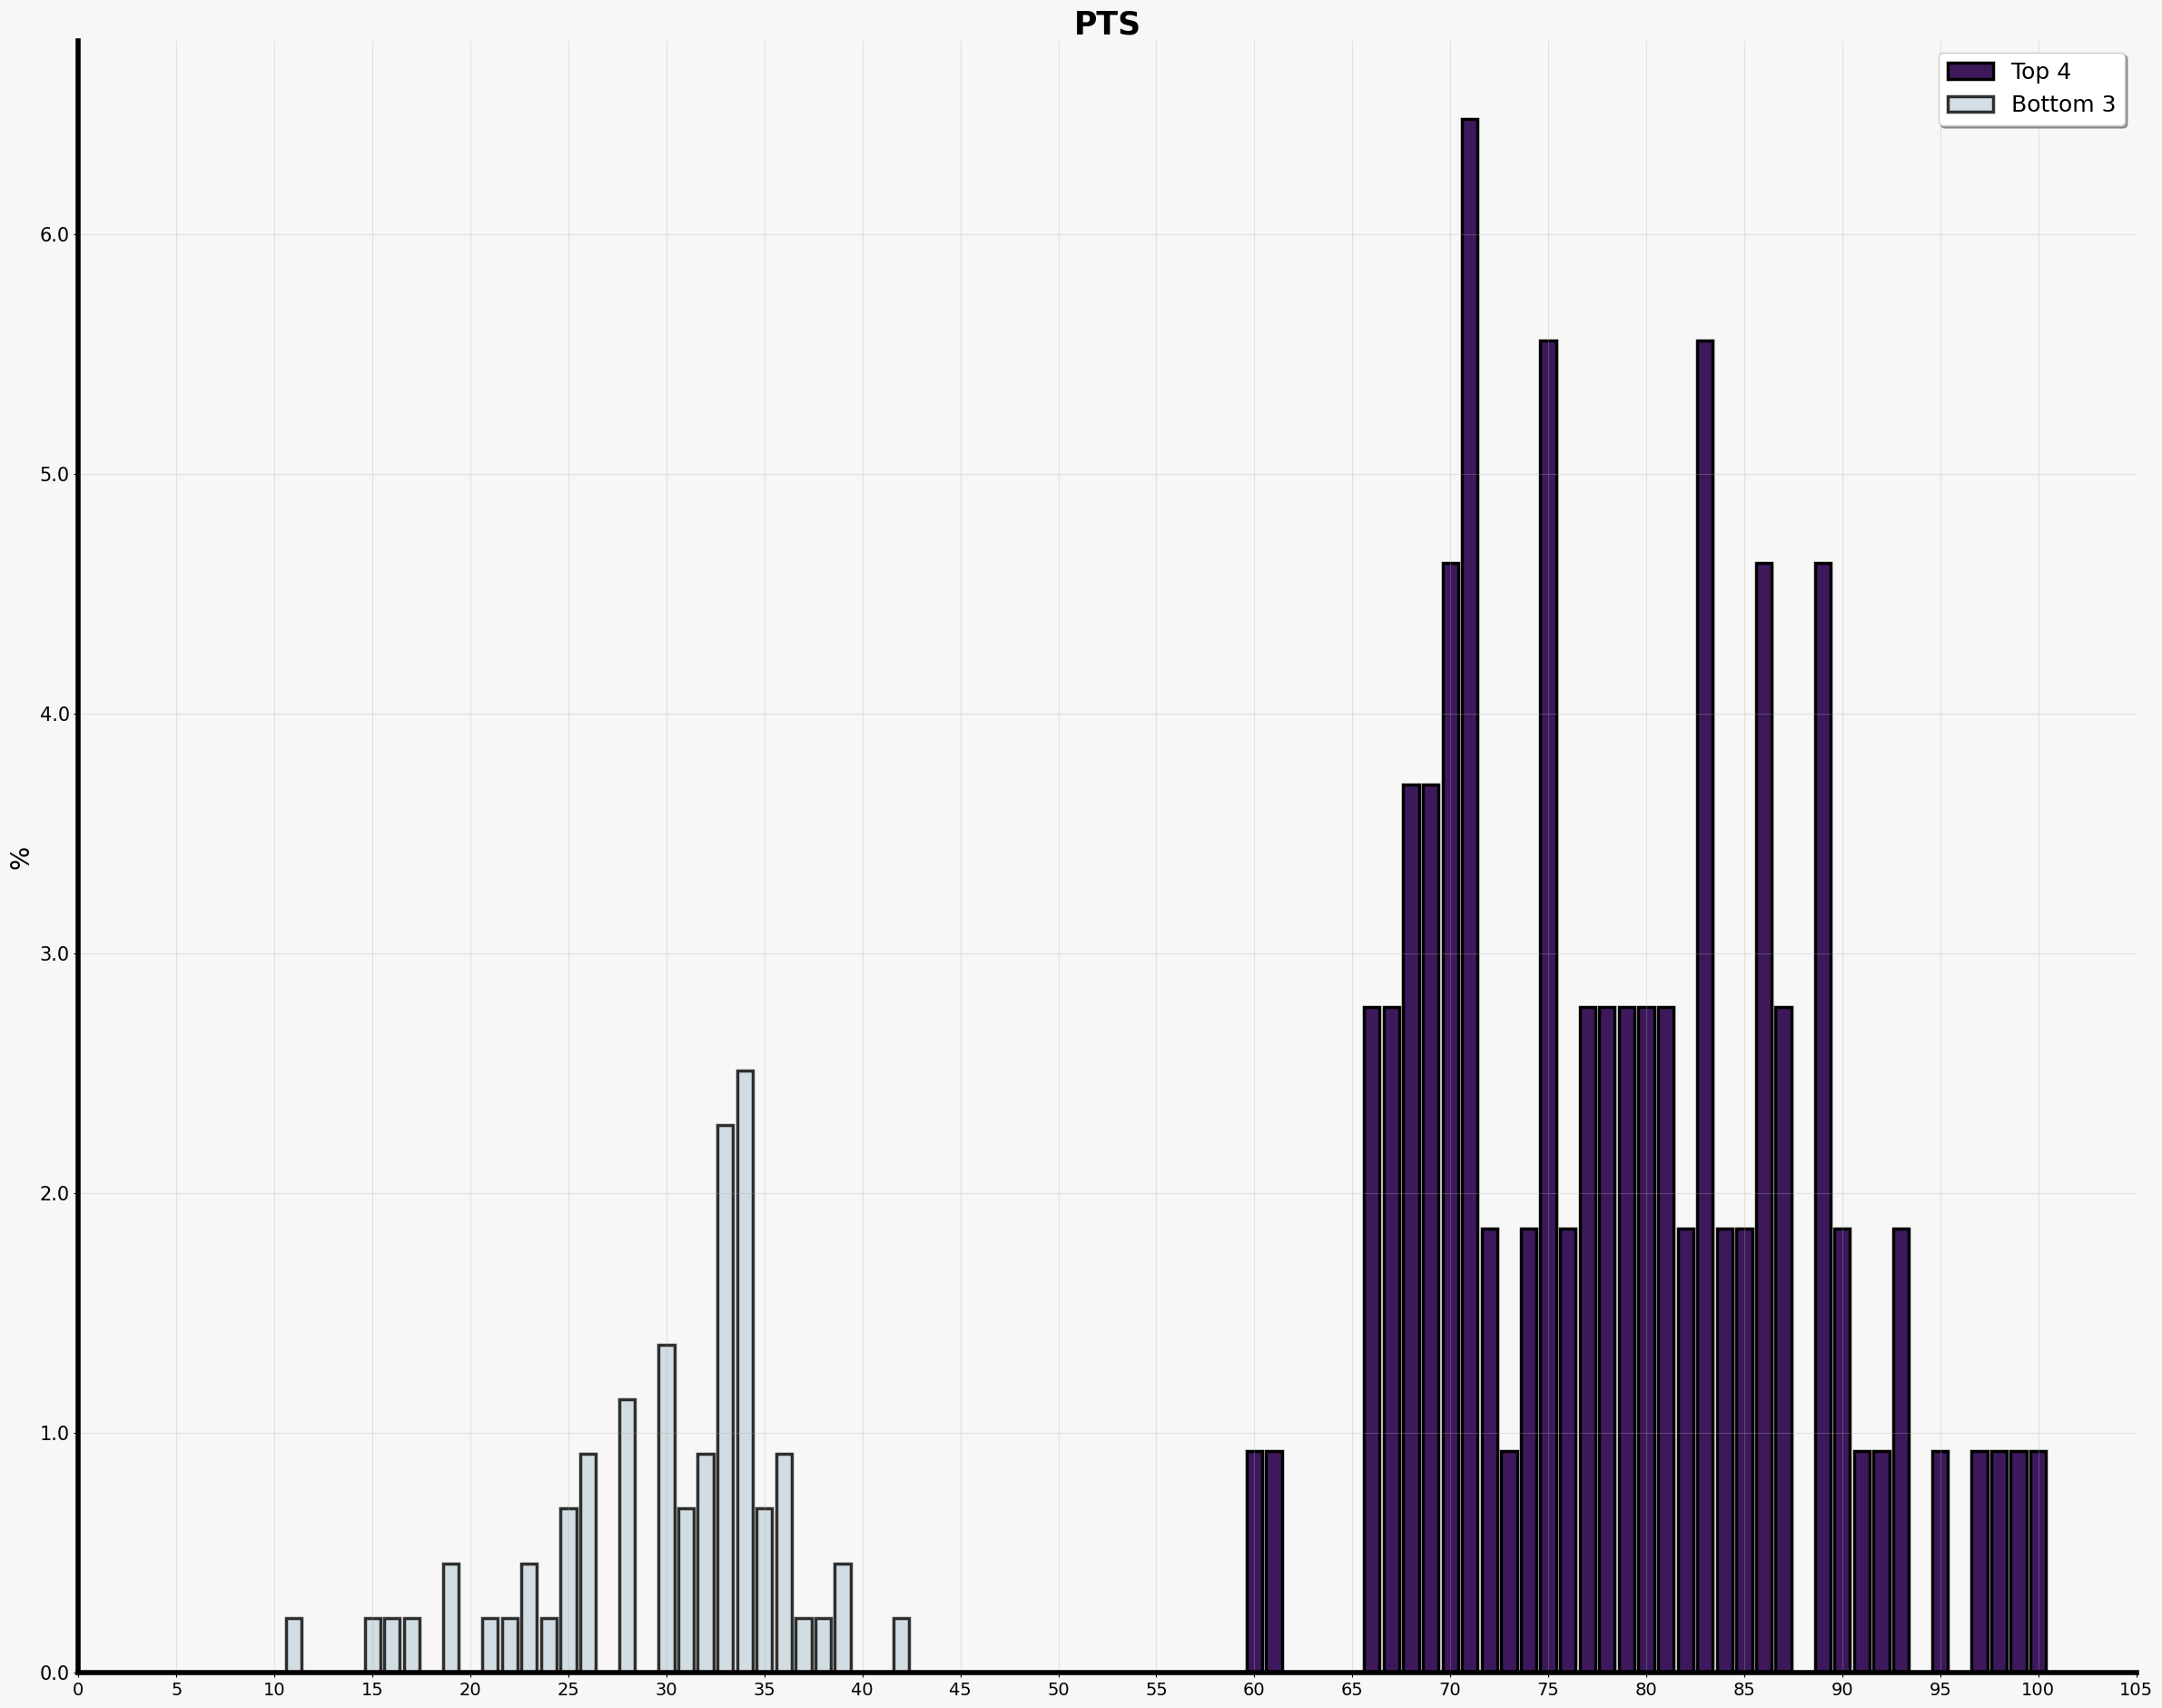

In [159]:
fig, ax = plt.subplots(1, 1, figsize=(25,20))
col = 'Pts'

t4_index = top_four[col].value_counts().index
t4_values = top_four[col].value_counts().values
b3_index = bottom_three[col].value_counts().index
b3_values = bottom_three[col].value_counts().values

ax.bar(x=t4_index, height=t4_values/1.08, color=t4_color, edgecolor='black', alpha=1, linewidth=2.5, label='Top 4')
ax.bar(x=b3_index, height=b3_values/4.38, color=b3_color, edgecolor='black', alpha=0.8, linewidth=2.5, label='Bottom 3')

ax.grid(which='major', axis='x', zorder=0, alpha=0.3)
ax.grid(which='major', axis='y', zorder=0, alpha=0.3)

ax.set_xticks(np.arange(0, 110, 5))
ax.set_title(col.upper(), weight='bold', fontsize=25)
ax.set_ylabel('%', fontsize=20)
ax.set_xticklabels(ax.get_xticks(), fontsize=20)
ax.set_yticklabels(ax.get_yticks(), fontsize=15)
ax.xaxis.set_tick_params(labelsize=14)
ax.set_facecolor(b_color)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)

ax.legend(loc=1, shadow=True, fontsize=18)

fig.set_facecolor(b_color)
fig.tight_layout(pad=5)
plt.show()

In [160]:
plt.savefig('/kaggle/working/plot.png', format='png')


<Figure size 640x480 with 0 Axes>

#### **Points Distribution**

#### **GF and GA Distributions**

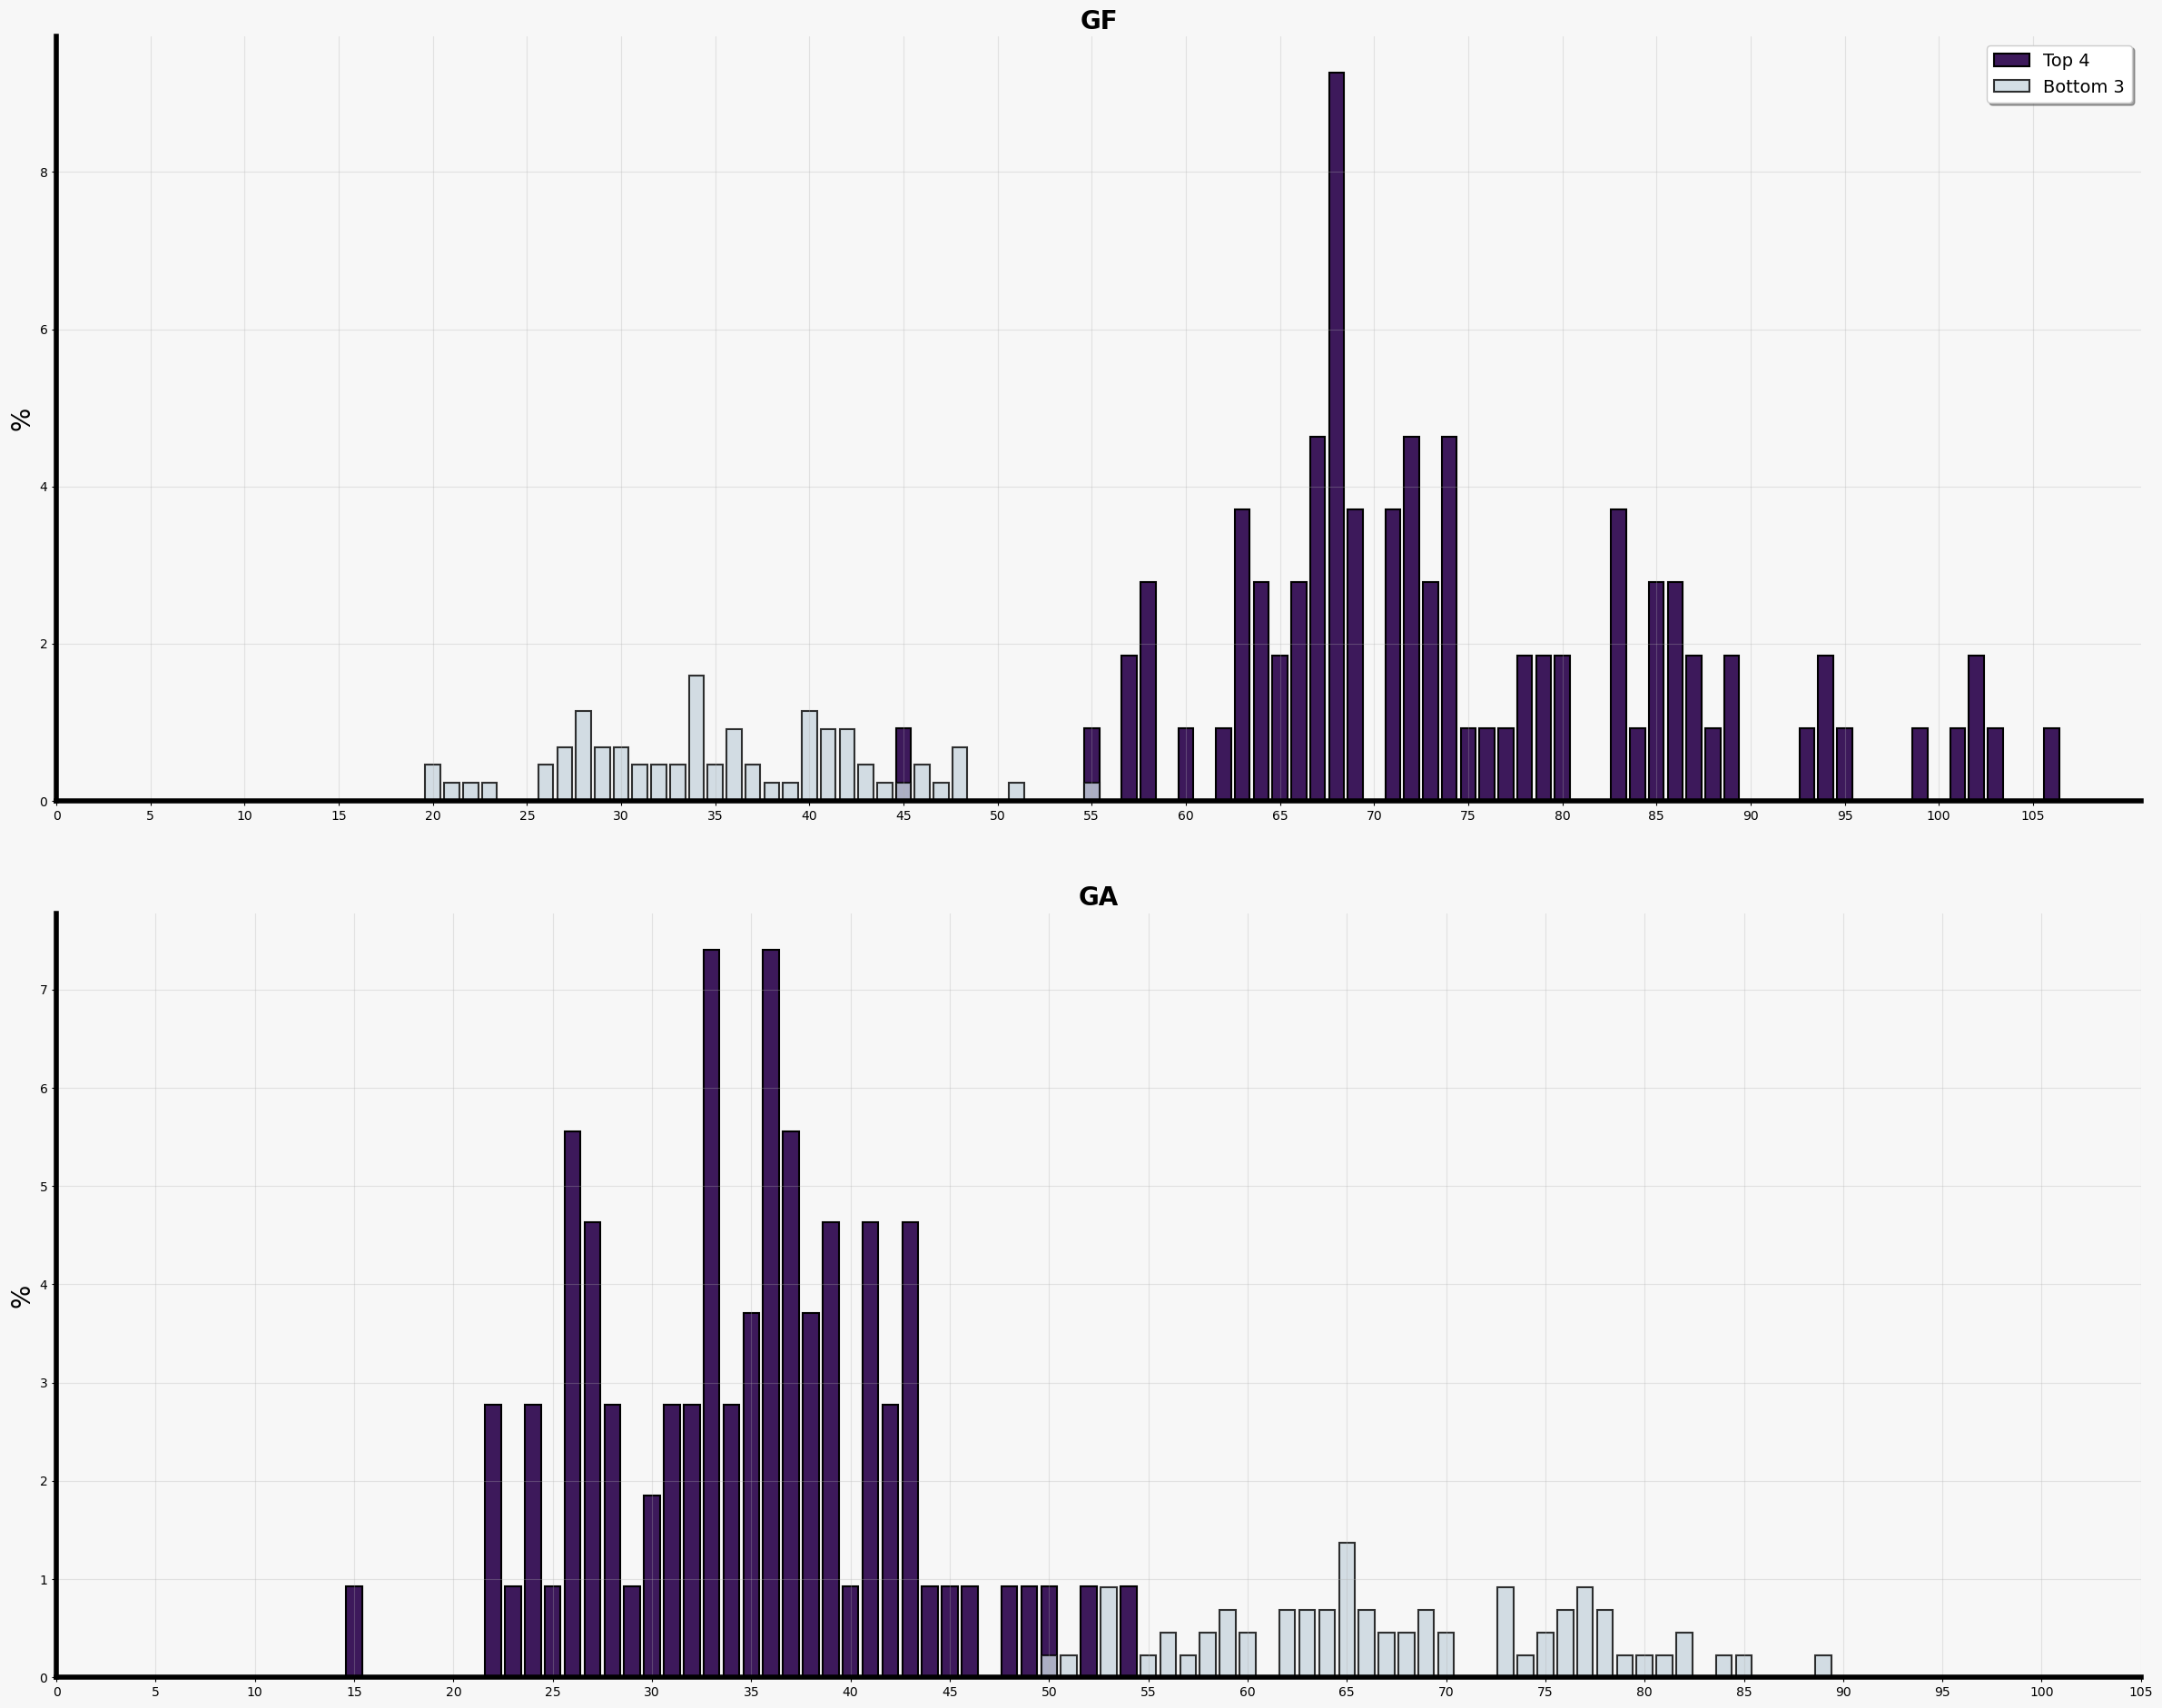

In [161]:
fig, ax = plt.subplots(2, 1, figsize=(25,20))
cols = ['GF','GA']

for i, col in enumerate(cols):
    t4_index = top_four[col].value_counts().index
    t4_values = top_four[col].value_counts().values
    b3_index = bottom_three[col].value_counts().index
    b3_values = bottom_three[col].value_counts().values
    
    ax.flatten()[i].bar(x=t4_index, height=t4_values/1.08, color=t4_color, edgecolor='black', alpha=1, linewidth=1.5, label='Top 4')
    ax.flatten()[i].bar(x=b3_index, height=b3_values/4.38, color=b3_color, edgecolor='black', alpha=0.8, linewidth=1.5, label='Bottom 3')
    
    ax.flatten()[i].grid(which='major', axis='x', zorder=0, alpha=0.3)
    ax.flatten()[i].grid(which='major', axis='y', zorder=0, alpha=0.3)
    
    ax.flatten()[i].set_xticks(np.arange(0, 110, 5))
    ax.flatten()[i].set_title(col.upper(), weight='bold', fontsize=20)
    ax.flatten()[i].set_ylabel('%', fontsize=20)
    ax.flatten()[i].set_facecolor(b_color)
    
    ax.flatten()[i].spines['top'].set_visible(False)
    ax.flatten()[i].spines['right'].set_visible(False)
    ax.flatten()[i].spines['bottom'].set_linewidth(4)
    ax.flatten()[i].spines['left'].set_linewidth(4)
    
    if i == 0:
        ax.flatten()[i].legend(loc=1, shadow=True, fontsize=14)

fig.set_facecolor(b_color)
fig.set_edgecolor('black')
fig.tight_layout(pad=5)
plt.show()

In [162]:
plt.savefig('/kaggle/working/plot.png', format='png')


<Figure size 640x480 with 0 Axes>

In [163]:
past_seasons_df.loc[(past_seasons_df['Pos'] == 4) & (past_seasons_df['GD'] < 0)]

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts
83,2004-05,4,Everton,38,18,7,13,45,46,-1,61


Everton is the only team to finish in the top four with a negative GD from the seasons covered in provided data.

# **Train Model With Data**

In [164]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Define the ANN model
def build_ann(input_dim):
    model = Sequential()
    model.add(Dense(units=6, kernel_initializer='uniform', activation='relu', input_dim=input_dim))
    model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train models and print evaluation metrics
def train(X, y, X_valid, y_valid):
    knn = KNeighborsClassifier(n_neighbors=5)
    dt  = DecisionTreeClassifier(max_depth=5)
    rf = RandomForestClassifier(n_estimators=100, max_features=5)
    ann = KerasClassifier(build_fn=lambda: build_ann(X.shape[1]), epochs=100, batch_size=10, verbose=0)
    svm = SVC(kernel='linear')
    
    # Fit models
    rf.fit(X, y)
    ann.fit(X, y)
    knn.fit(X, y)
    dt.fit(X, y)
    svm.fit(X, y)

    # Make predictions
    ann_pred = (ann.predict(X_valid) > 0.5).astype(int).ravel()
    svm_pred = svm.predict(X_valid)
    knn_pred = knn.predict(X_valid)
    dt_pred = dt.predict(X_valid)
    rf_pred = rf.predict(X_valid)

    # Print evaluation
    print(f'K-Nearest Neighbors: {round(accuracy_score(y_valid, knn_pred), 5) * 100:.0f}%')
    print(f'Random Forest: {round(accuracy_score(y_valid, rf_pred), 5) * 100:.0f}%')
    print(f'Artificial Neural Network: {round(accuracy_score(y_valid, ann_pred), 5) * 100:.0f}%')
    print(f'Support Vector Machine: {round(accuracy_score(y_valid, svm_pred), 5) * 100:.0f}%')
    print(f'Decision Tree: {round(accuracy_score(y_valid, dt_pred), 5) * 100:.0f}%')

    return [rf, ann, svm, dt, knn]

    print(f'K-Nearest Neighbors: {round(precision_score(y_valid, knn_pred), 5) * 100:.0f}%')
    print(f'Random Forest: {round(precision_score(y_valid, rf_pred), 5) * 100:.0f}%')
    print(f'Artificial Neural Network: {round(precision_score(y_valid, ann_pred), 5) * 100:.0f}%')
    print(f'Support Vector Machine: {round(precision_score(y_valid, svm_pred), 5) * 100:.0f}%')
    print(f'Decision Tree: {round(precision_score(y_valid, dt_pred), 5) * 100:.0f}%')

    return [rf, ann, svm, dt, knn]

    print(f'K-Nearest Neighbors: {round(recall_score(y_valid, knn_pred), 5) * 100:.0f}%')
    print(f'Random Forest: {round(recall_score(y_valid, rf_pred), 5) * 100:.0f}%')
    print(f'Artificial Neural Network: {round(recall_score(y_valid, ann_pred), 5) * 100:.0f}%')
    print(f'Support Vector Machine: {round(recall_score(y_valid, svm_pred), 5) * 100:.0f}%')
    print(f'Decision Tree: {round(recall_score(y_valid, dt_pred), 5) * 100:.0f}%')

    return [rf, ann, svm, dt, knn]

    print(f'K-Nearest Neighbors: {round(f1_score(y_valid, knn_pred), 5) * 100:.0f}%')
    print(f'Random Forest: {round(f1_score(y_valid, rf_pred), 5) * 100:.0f}%')
    print(f'Artificial Neural Network: {round(f1_score(y_valid, ann_pred), 5) * 100:.0f}%')
    print(f'Support Vector Machine: {round(f1_score(y_valid, svm_pred), 5) * 100:.0f}%')
    print(f'Decision Tree: {round(f1_score(y_valid, dt_pred), 5) * 100:.0f}%')

    return [rf, ann, svm, dt, knn]

    # Plot learning curves for different models
def plot_learning(X, y):
    rf = RandomForestClassifier(n_estimators=100, max_features=7)
    ann = KerasClassifier(build_fn=lambda: build_ann(X.shape[1]), epochs=100, batch_size=10, verbose=0)
    svm = SVC(kernel='linear')
    knn = KNeighborsClassifier(n_neighbors=5)
    dt  = DecisionTreeClassifier(max_depth=5)

    models = [rf, knn, ann, svm, dt]
    model_names = ['Random Forest', 'K-Nearest Neighbors', 'Artificial Neural Network', 'Support Vector Machine', 'Decision Tree']

    fig, ax = plt.subplots(1, 5, figsize=(24, 5))

    for i in range(5):
        train_sizes, train_scores, test_scores = learning_curve(models[i], X, y, cv=5, n_jobs=-1)
        ax.flatten()[i].plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='blue', label='Training')
        ax.flatten()[i].plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='brown', label='Cross-Validation')
        ax.flatten()[i].legend()
        ax.flatten()[i].set_title(f'{model_names[i]} Learning Curve')
        ax.flatten()[i].set_xlabel('Training Size')
        ax.flatten()[i].set_ylabel('Score')

    plt.show()


In [165]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Define the ANN model
def build_ann(input_dim):
    model = Sequential()
    model.add(Dense(units=6, kernel_initializer='uniform', activation='relu', input_dim=input_dim))
    model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train models and print evaluation metrics
def train(X, y, X_valid, y_valid):
    knn = KNeighborsClassifier(n_neighbors=5)
    dt  = DecisionTreeClassifier(max_depth=5)
    rf = RandomForestClassifier(n_estimators=100, max_features=5)
    ann = KerasClassifier(build_fn=lambda: build_ann(X.shape[1]), epochs=100, batch_size=10, verbose=0)
    svm = SVC(kernel='linear')

    # Fit models
    rf.fit(X, y)
    ann.fit(X, y)
    knn.fit(X, y)
    dt.fit(X, y)
    svm.fit(X, y)

    # Make predictions
    ann_pred = (ann.predict(X_valid) > 0.5).astype(int).ravel()
    svm_pred = svm.predict(X_valid)
    knn_pred = knn.predict(X_valid)
    dt_pred = dt.predict(X_valid)
    rf_pred = rf.predict(X_valid)

    # Accuracy
    print(f'K-Nearest Neighbors Accuracy: {accuracy_score(y_valid, knn_pred):.2%}')
    print(f'Random Forest Accuracy: {accuracy_score(y_valid, rf_pred):.2%}')
    print(f'Artificial Neural Network Accuracy: {accuracy_score(y_valid, ann_pred):.2%}')
    print(f'Support Vector Machine Accuracy: {accuracy_score(y_valid, svm_pred):.2%}')
    print(f'Decision Tree Accuracy: {accuracy_score(y_valid, dt_pred):.2%}')

    # Precision
    print(f'K-Nearest Neighbors Precision: {precision_score(y_valid, knn_pred):.2%}')
    print(f'Random Forest Precision: {precision_score(y_valid, rf_pred):.2%}')
    print(f'Artificial Neural Network Precision: {precision_score(y_valid, ann_pred):.2%}')
    print(f'Support Vector Machine Precision: {precision_score(y_valid, svm_pred):.2%}')
    print(f'Decision Tree Precision: {precision_score(y_valid, dt_pred):.2%}')

    # Recall
    print(f'K-Nearest Neighbors Recall: {recall_score(y_valid, knn_pred):.2%}')
    print(f'Random Forest Recall: {recall_score(y_valid, rf_pred):.2%}')
    print(f'Artificial Neural Network Recall: {recall_score(y_valid, ann_pred):.2%}')
    print(f'Support Vector Machine Recall: {recall_score(y_valid, svm_pred):.2%}')
    print(f'Decision Tree Recall: {recall_score(y_valid, dt_pred):.2%}')

    # F1 Score
    print(f'K-Nearest Neighbors F1 Score: {f1_score(y_valid, knn_pred):.2%}')
    print(f'Random Forest F1 Score: {f1_score(y_valid, rf_pred):.2%}')
    print(f'Artificial Neural Network F1 Score: {f1_score(y_valid, ann_pred):.2%}')
    print(f'Support Vector Machine F1 Score: {f1_score(y_valid, svm_pred):.2%}')
    print(f'Decision Tree F1 Score: {f1_score(y_valid, dt_pred):.2%}')

    return [rf, ann, svm, dt, knn]

# Plot learning curves for different models
def plot_learning(X, y):
    rf = RandomForestClassifier(n_estimators=100, max_features=7)
    ann = KerasClassifier(build_fn=lambda: build_ann(X.shape[1]), epochs=100, batch_size=10, verbose=0)
    svm = SVC(kernel='linear')
    knn = KNeighborsClassifier(n_neighbors=5)
    dt  = DecisionTreeClassifier(max_depth=5)

    models = [rf, knn, ann, svm, dt]
    model_names = ['Random Forest', 'K-Nearest Neighbors', 'Artificial Neural Network', 'Support Vector Machine', 'Decision Tree']

    fig, ax = plt.subplots(1, 5, figsize=(24, 5))

    for i in range(5):
        train_sizes, train_scores, test_scores = learning_curve(models[i], X, y, cv=5, n_jobs=-1)
        ax.flatten()[i].plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='blue', label='Training')
        ax.flatten()[i].plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='brown', label='Cross-Validation')
        ax.flatten()[i].legend()
        ax.flatten()[i].set_title(f'{model_names[i]} Learning Curve')
        ax.flatten()[i].set_xlabel('Training Size')
        ax.flatten()[i].set_ylabel('Score')

    plt.show()


In [166]:
past_seasons = past_seasons_df.drop('Team', axis=1)
past_seasons['Top 4'] = 0
past_seasons['Bottom 3'] = 0

past_seasons.loc[past_seasons['Pos'] <= 4, 'Top 4'] = 1
past_seasons.loc[past_seasons['Pos'] >= 18, 'Bottom 3'] = 1
p_seasons = past_seasons.drop(columns=['Pos','Season','Pld'], axis=1)

p_seasons


,W,D,L,GF,GA,GD,Pts,Top 4,Bottom 3
0,24,8,6,79,31,48,80,1,0
1,20,10,8,63,38,25,70,1,0
2,20,9,9,71,39,32,69,1,0
3,20,8,10,64,43,21,68,1,0
4,20,6,12,57,42,15,66,0,0
...,...,...,...,...,...,...,...,...,...
455,9,11,18,38,68,-30,38,0,0
456,8,12,18,34,57,-23,36,0,0
457,9,7,22,51,68,-17,34,0,1
458,7,10,21,48,78,-30,31,0,1


In [167]:
# Split Train and Test sets: first is for predicting top 4, second is for predicting bottom three
X_seasons_train, X_seasons_test, y_seasons_train, y_seasons_test = train_test_split(p_seasons.drop(columns=['Top 4','Bottom 3'], axis=1), 
                                                                        p_seasons['Top 4'], 
                                                                        test_size=0.2, 
                                                                        random_state=2023, 
                                                                        stratify=p_seasons['Top 4'])

X_seasons2_train, X_seasons2_test, y_seasons2_train, y_seasons2_test = train_test_split(p_seasons.drop(columns=['Top 4','Bottom 3'], axis=1), 
                                                                        p_seasons['Bottom 3'], 
                                                                        test_size=0.2, 
                                                                        random_state=2023, 
                                                                        stratify=p_seasons['Bottom 3'])

# Split Test set for validation set
X_seasons_valid, X_seasons_test, y_seasons_valid, y_seasons_test = train_test_split(X_seasons_test, 
                                                                        y_seasons_test, 
                                                                        test_size=0.2, 
                                                                        random_state=2023, 
                                                                        stratify=y_seasons_test)

X_seasons2_valid, X_seasons2_test, y_seasons2_valid, y_seasons2_test = train_test_split(X_seasons2_test, 
                                                                        y_seasons2_test, 
                                                                        test_size=0.2, 
                                                                        random_state=2023, 
                                                                        stratify=y_seasons2_test)


In [168]:
X_seasons_test

,W,D,L,GF,GA,GD,Pts
272,11,7,20,40,51,-11,40
317,9,10,19,44,65,-21,37
97,7,12,19,41,62,-21,33
265,21,6,11,55,51,4,69
287,16,8,14,46,49,-3,56
275,10,7,21,38,53,-15,37
304,19,9,10,49,35,14,66
356,7,15,16,37,56,-19,36
67,14,11,13,48,56,-8,53
48,15,6,17,47,54,-7,51


### **Top 4 Learning**

In [169]:
import pandas as pd

# Ensure current_season is defined (replace with your actual DataFrame)
current_season = pd.DataFrame({
    'Team','Pld','W','L','D','GF','GA','GD','Pts'
})

# Check if 'missing_column' exists, if not, add it with a default value of 0
if 'missing_column' not in current_season.columns:
    current_season['missing_column'] = 0

print(current_season)


      0  missing_column
0   Pld               0
1    GF               0
2     L               0
3    GD               0
4  Team               0
5     W               0
6    GA               0
7     D               0
8   Pts               0


In [170]:
print(current_season.shape)  # Should match the shape of training data (without the target column)


(9, 2)


In [171]:
 t4_rf, t4_ann, t4_svm, t4_knn, t4_dt = train(X_seasons_train, y_seasons_train, X_seasons_valid, y_seasons_valid)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


3/3 [==============================] - 0s 3ms/step
K-Nearest Neighbors Accuracy: 97.26%
Random Forest Accuracy: 97.26%
Artificial Neural Network Accuracy: 97.26%
Support Vector Machine Accuracy: 97.26%
Decision Tree Accuracy: 94.52%
K-Nearest Neighbors Precision: 100.00%
Random Forest Precision: 100.00%
Artificial Neural Network Precision: 100.00%
Support Vector Machine Precision: 100.00%
Decision Tree Precision: 100.00%
K-Nearest Neighbors Recall: 85.71%
Random Forest Recall: 85.71%
Artificial Neural Network Recall: 85.71%
Support Vector Machine Recall: 85.71%
Decision Tree Recall: 71.43%
K-Nearest Neighbors F1 Score: 92.31%
Random Forest F1 Score: 92.31%
Artificial Neural Network F1 Score: 92.31%
Support Vector Machine F1 Score: 92.31%
Decision Tree F1 Score: 83.33%


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


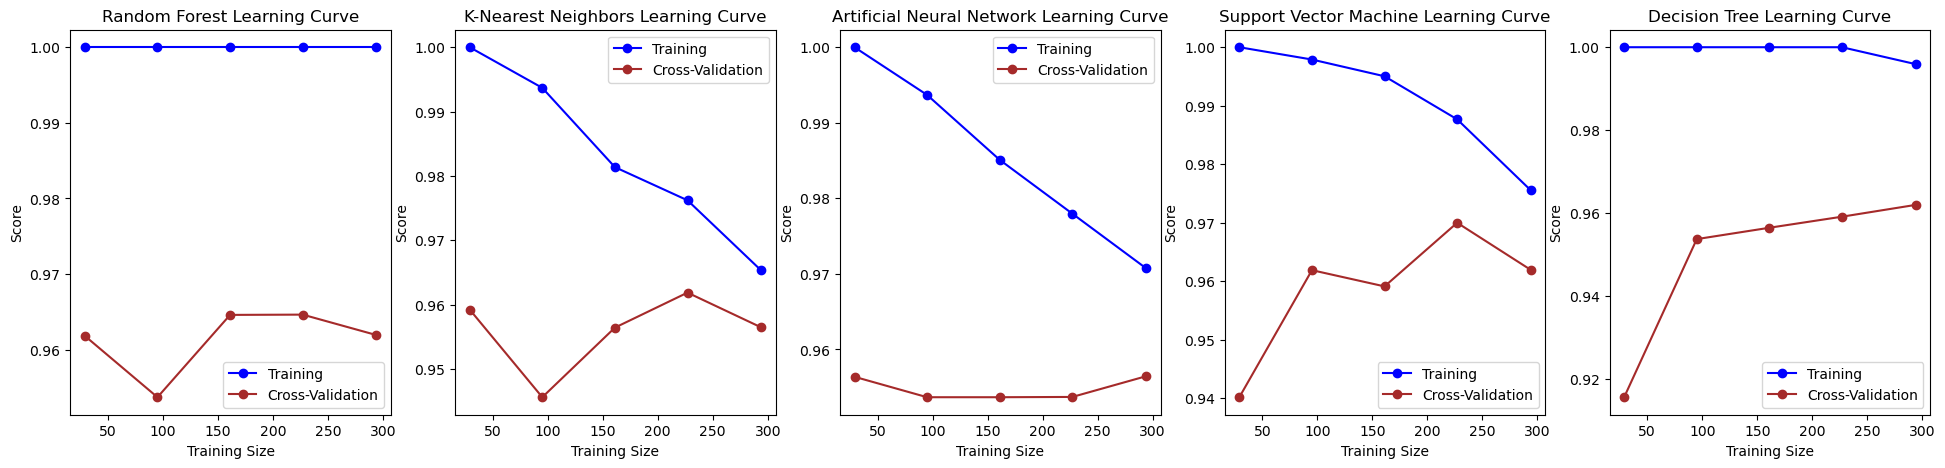

In [172]:
plot_learning(X_seasons_train, y_seasons_train)

In [173]:
plt.savefig('/kaggle/working/plot.png', format='png')


<Figure size 640x480 with 0 Axes>

### **Bottom 3 Learning**

In [174]:
b3_rf, b3_ann, b3_svm, b3_knn, b3_dt = train(X_seasons2_train, y_seasons2_train, X_seasons2_valid, y_seasons2_valid)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


3/3 [==============================] - 0s 4ms/step
K-Nearest Neighbors Accuracy: 95.89%
Random Forest Accuracy: 97.26%
Artificial Neural Network Accuracy: 97.26%
Support Vector Machine Accuracy: 97.26%
Decision Tree Accuracy: 97.26%
K-Nearest Neighbors Precision: 90.00%
Random Forest Precision: 100.00%
Artificial Neural Network Precision: 100.00%
Support Vector Machine Precision: 84.62%
Decision Tree Precision: 100.00%
K-Nearest Neighbors Recall: 81.82%
Random Forest Recall: 81.82%
Artificial Neural Network Recall: 81.82%
Support Vector Machine Recall: 100.00%
Decision Tree Recall: 81.82%
K-Nearest Neighbors F1 Score: 85.71%
Random Forest F1 Score: 90.00%
Artificial Neural Network F1 Score: 90.00%
Support Vector Machine F1 Score: 91.67%
Decision Tree F1 Score: 90.00%


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


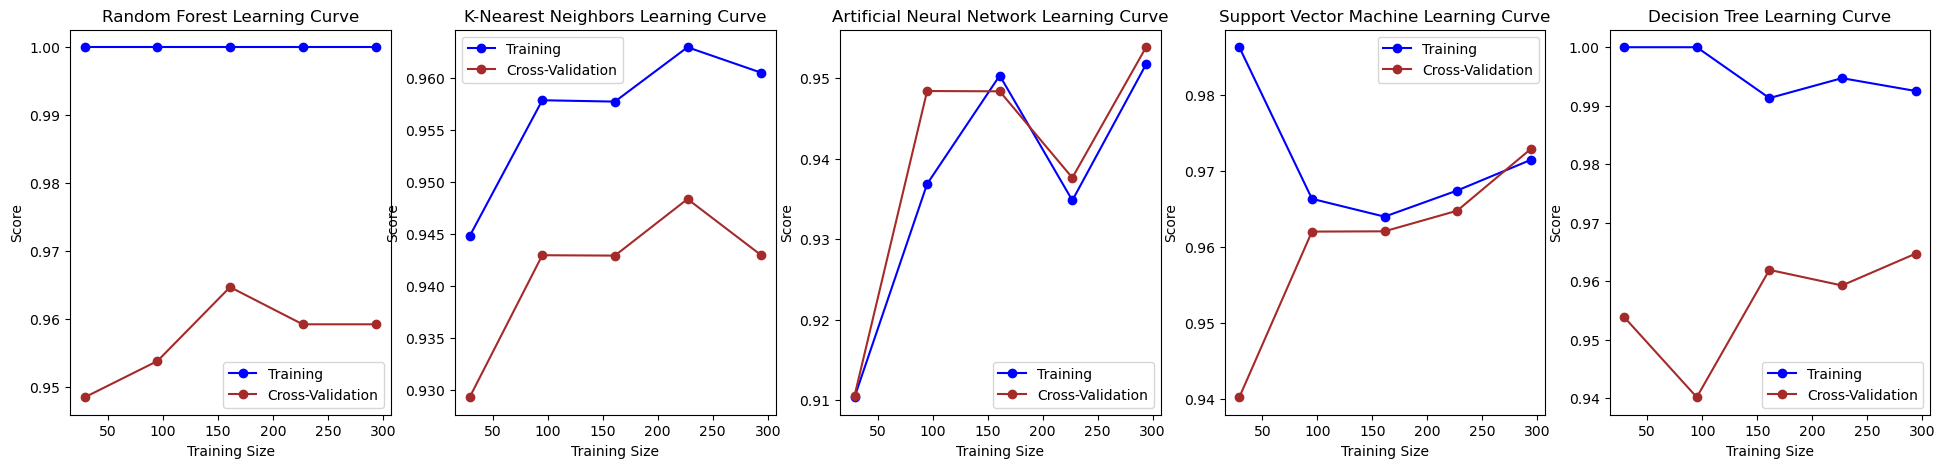

In [175]:
plot_learning(X_seasons2_train, y_seasons2_train)

In [176]:
plt.savefig('/kaggle/working/plot.png', format='png')


<Figure size 640x480 with 0 Axes>

#### Current season standings dataframe

# **Predicting Current Season Standings**

In [177]:
#create dataframe for current season; edited csv from https://www.footballwebpages.co.uk/premier-league/league-table to match other dataframes
current_season_df = pd.read_csv('//kaggle/input/newepl/eplcurrent.csv')
current_season_df.index += 1

current_season_df

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts
1,2023-24,1,Manchester City,38,28,7,3,96,34,62,91
2,2023-24,2,Arsenal,38,28,5,5,91,29,62,89
3,2023-24,3,Liverpool,38,24,10,4,86,41,45,82
4,2023-24,4,Aston Villa,38,20,8,10,76,61,15,68
5,2023-24,5,Tottenham Hotspur,38,20,6,12,74,61,13,66
6,2023-24,6,Chelsea,38,18,9,11,77,63,14,63
7,2023-24,7,Newcastle United,38,18,6,14,85,62,23,60
8,2023-24,8,Manchester United,38,18,6,14,57,58,-1,60
9,2023-24,9,West Ham United,38,14,10,14,60,74,-14,52
10,2023-24,10,Crystal Palace,38,13,10,15,57,58,-1,49


In [178]:
#create dataframe for current season; edited csv from https://www.footballwebpages.co.uk/premier-league/league-table to match other dataframes
current_season_df = pd.read_csv('//kaggle/input/newepl/eplcurrent.csv')
current_season_df.index += 1

current_season_df

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts
1,2023-24,1,Manchester City,38,28,7,3,96,34,62,91
2,2023-24,2,Arsenal,38,28,5,5,91,29,62,89
3,2023-24,3,Liverpool,38,24,10,4,86,41,45,82
4,2023-24,4,Aston Villa,38,20,8,10,76,61,15,68
5,2023-24,5,Tottenham Hotspur,38,20,6,12,74,61,13,66
6,2023-24,6,Chelsea,38,18,9,11,77,63,14,63
7,2023-24,7,Newcastle United,38,18,6,14,85,62,23,60
8,2023-24,8,Manchester United,38,18,6,14,57,58,-1,60
9,2023-24,9,West Ham United,38,14,10,14,60,74,-14,52
10,2023-24,10,Crystal Palace,38,13,10,15,57,58,-1,49


In [179]:
current_season = current_season_df.copy()
current_season = current_season.reset_index(drop=True)
current_season['Top 4'] = 0
current_season['Bottom 3'] = 0

current_season.loc[current_season['Pos'] <= 4, 'Top 4'] = 1
current_season.loc[current_season['Pos'] >= 18, 'Bottom 3'] = 1

y_test_t4 = current_season['Top 4'].copy()
y_test_b3 = current_season['Bottom 3'].copy()

teams = current_season[['Pos','Team']].copy()

In [180]:
current_season = current_season.drop(columns=['Season','Pld','Pos','Team','Top 4', 'Bottom 3'])
current_season

,W,D,L,GF,GA,GD,Pts
0,28,7,3,96,34,62,91
1,28,5,5,91,29,62,89
2,24,10,4,86,41,45,82
3,20,8,10,76,61,15,68
4,20,6,12,74,61,13,66
5,18,9,11,77,63,14,63
6,18,6,14,85,62,23,60
7,18,6,14,57,58,-1,60
8,14,10,14,60,74,-14,52
9,13,10,15,57,58,-1,49


In [181]:
current_season = current_season_df.copy()
current_season = current_season.reset_index(drop=True)
current_season['Top 4'] = 0
current_season['Bottom 3'] = 0

current_season.loc[current_season['Pos'] <= 4, 'Top 4'] = 1
current_season.loc[current_season['Pos'] >= 18, 'Bottom 3'] = 1

y_test_t4 = current_season['Top 4'].copy()
y_test_b3 = current_season['Bottom 3'].copy()

teams = current_season[['Pos','Team']].copy()

In [182]:
current_season = current_season.drop(columns=['Season','Pld','Pos','Team','Top 4', 'Bottom 3'])
current_season

,W,D,L,GF,GA,GD,Pts
0,28,7,3,96,34,62,91
1,28,5,5,91,29,62,89
2,24,10,4,86,41,45,82
3,20,8,10,76,61,15,68
4,20,6,12,74,61,13,66
5,18,9,11,77,63,14,63
6,18,6,14,85,62,23,60
7,18,6,14,57,58,-1,60
8,14,10,14,60,74,-14,52
9,13,10,15,57,58,-1,49


In [183]:
y_test_t4

0     1
1     1
2     1
3     1
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
Name: Top 4, dtype: int64

In [184]:
y_test_b3

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    1
18    1
19    1
Name: Bottom 3, dtype: int64

### Predicting top 4

In [185]:
# Accuracy
print((f't4_ann: {round(accuracy_score(y_test_t4, t4_ann.predict(current_season)) * 100, 2)}% \n'
       f't4_rf: {round(accuracy_score(y_test_t4, t4_rf.predict(current_season)) * 100, 2)}% \n'
       f't4_svm: {round(accuracy_score(y_test_t4, t4_svm.predict(current_season)) * 100, 2)}% \n'
       f't4_knn: {round(accuracy_score(y_test_t4, t4_knn.predict(current_season)) * 100, 2)}% \n'
       f't4_dt: {round(accuracy_score(y_test_t4, t4_dt.predict(current_season)) * 100, 2)}%'))

# Precision
print((f't4_ann: {round(precision_score(y_test_t4, t4_ann.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_rf: {round(precision_score(y_test_t4, t4_rf.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_svm: {round(precision_score(y_test_t4, t4_svm.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_knn: {round(precision_score(y_test_t4, t4_knn.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_dt: {round(precision_score(y_test_t4, t4_dt.predict(current_season), average="binary") * 100, 2)}%'))

# Recall
print((f't4_ann: {round(recall_score(y_test_t4, t4_ann.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_rf: {round(recall_score(y_test_t4, t4_rf.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_svm: {round(recall_score(y_test_t4, t4_svm.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_knn: {round(recall_score(y_test_t4, t4_knn.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_dt: {round(recall_score(y_test_t4, t4_dt.predict(current_season), average="binary") * 100, 2)}%'))

# F1 Score
print((f't4_ann: {round(f1_score(y_test_t4, t4_ann.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_rf: {round(f1_score(y_test_t4, t4_rf.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_svm: {round(f1_score(y_test_t4, t4_svm.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_knn: {round(f1_score(y_test_t4, t4_knn.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_dt: {round(f1_score(y_test_t4, t4_dt.predict(current_season), average="binary") * 100, 2)}%'))


1/1 [==============================] - 0s 34ms/step
t4_ann: 95.0% 
t4_rf: 95.0% 
t4_svm: 95.0% 
t4_knn: 90.0% 
t4_dt: 95.0%
1/1 [==============================] - 0s 41ms/step
t4_ann: 100.0% 
t4_rf: 80.0% 
t4_svm: 100.0% 
t4_knn: 75.0% 
t4_dt: 100.0%
1/1 [==============================] - 0s 37ms/step
t4_ann: 75.0% 
t4_rf: 100.0% 
t4_svm: 75.0% 
t4_knn: 75.0% 
t4_dt: 75.0%
1/1 [==============================] - 0s 45ms/step
t4_ann: 85.71% 
t4_rf: 88.89% 
t4_svm: 85.71% 
t4_knn: 75.0% 
t4_dt: 85.71%


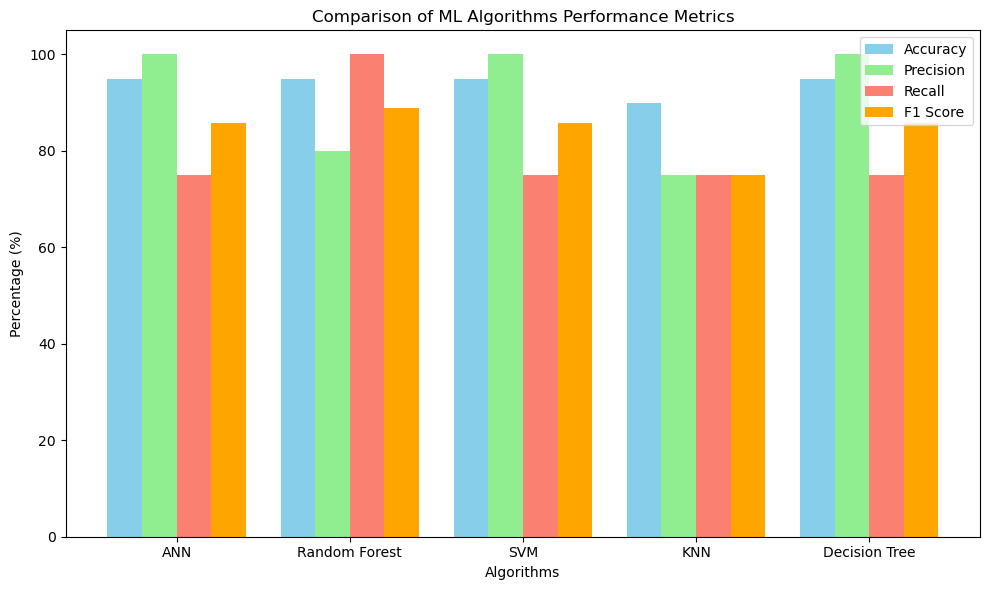

In [186]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for the algorithms
models = ['ANN', 'Random Forest', 'SVM', 'KNN', 'Decision Tree']
accuracy = [95.00, 95.00, 95.00, 90.00, 95.00]
precision = [100.00, 80.00, 100.00, 75.00, 100.00]
recall = [75.00, 100.00, 75.00, 75.00, 75.00]
f1_score = [85.71, 88.89, 85.71, 75.00, 85.71]

# Create an array for bar positions
x = np.arange(len(models))

# Set width of the bars
width = 0.2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width*1.5, accuracy, width, label='Accuracy', color='skyblue')
ax.bar(x - width/2, precision, width, label='Precision', color='lightgreen')
ax.bar(x + width/2, recall, width, label='Recall', color='salmon')
ax.bar(x + width*1.5, f1_score, width, label='F1 Score', color='orange')

# Add labels, title, and ticks
ax.set_xlabel('Algorithms')
ax.set_ylabel('Percentage (%)')
ax.set_title('Comparison of ML Algorithms Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [187]:
plt.savefig('/kaggle/working/plot.png', format='png')


<Figure size 640x480 with 0 Axes>

In [188]:
# Calculate average prediction only for models that support predict_proba
probas = {
    'ANN': t4_ann.predict_proba(current_season)[:, 1],
    'RF': t4_rf.predict_proba(current_season)[:, 1],
    'SVM': t4_svm.decision_function(current_season),  # Use decision_function as an alternative
    'KNN': t4_knn.predict_proba(current_season)[:, 1],
    'DT': t4_dt.predict_proba(current_season)[:, 1]
}

# Convert decision_function to probabilities for SVM (use sigmoid function if needed)
from scipy.special import expit  # Sigmoid function
probas['SVM'] = expit(probas['SVM'])

# Average the probabilities
avg_pred_t4 = (probas['ANN'] + 
               probas['RF'] +
               probas['SVM'] + 
               probas['KNN'] +
               probas['DT']) / 5
avg_pred_t4


1/1 [==============================] - 0s 37ms/step


array([9.99943957e-01, 9.99935763e-01, 9.99514301e-01, 3.06914182e-01,
       4.10855224e-01, 6.07991658e-02, 8.33288436e-02, 8.59643582e-04,
       1.24982520e-05, 3.92446972e-05, 1.03501497e-05, 4.69541414e-06,
       1.13443555e-05, 2.14526372e-06, 1.85929666e-06, 8.37699148e-07,
       5.33652358e-08, 8.31500576e-10, 3.25803695e-10, 2.85615761e-13])

In [189]:
import pandas as pd

# Assuming avg_pred_t4 is defined and you want to use it
df_results = pd.concat([
    teams,
    pd.Series(avg_pred_t4, name='ensemble_result'),
    pd.Series(y_test_t4, name='Top 4')
], axis=1)

print(df_results.head())


   Pos               Team  ensemble_result  Top 4
0    1    Manchester City         0.999944      1
1    2            Arsenal         0.999936      1
2    3          Liverpool         0.999514      1
3    4        Aston Villa         0.306914      1
4    5  Tottenham Hotspur         0.410855      0


### Predicting bottom three

In [190]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming the following predictions and true values:
# y_test_b3 is your true labels
# b3_ann, b3_rf, b3_svm, b3_knn, b3_dt are your models

# Accuracy
print((f'b3_ann: {round(accuracy_score(y_test_b3, b3_ann.predict(current_season)) * 100, 2)}% \n'
       f'b3_rf: {round(accuracy_score(y_test_b3, b3_rf.predict(current_season)) * 100, 2)}% \n'
       f'b3_svm: {round(accuracy_score(y_test_b3, b3_svm.predict(current_season)) * 100, 2)}% \n'
       f'b3_knn: {round(accuracy_score(y_test_b3, b3_knn.predict(current_season)) * 100, 2)}% \n'
       f'b3_dt: {round(accuracy_score(y_test_b3, b3_dt.predict(current_season)) * 100, 2)}%'))

# Precision
print((f'b3_ann: {round(precision_score(y_test_b3, b3_ann.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_rf: {round(precision_score(y_test_b3, b3_rf.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_svm: {round(precision_score(y_test_b3, b3_svm.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_knn: {round(precision_score(y_test_b3, b3_knn.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_dt: {round(precision_score(y_test_b3, b3_dt.predict(current_season), average="binary") * 100, 2)}%'))

# Recall
print((f'b3_ann: {round(recall_score(y_test_b3, b3_ann.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_rf: {round(recall_score(y_test_b3, b3_rf.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_svm: {round(recall_score(y_test_b3, b3_svm.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_knn: {round(recall_score(y_test_b3, b3_knn.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_dt: {round(recall_score(y_test_b3, b3_dt.predict(current_season), average="binary") * 100, 2)}%'))

# F1 Score
print((f'b3_ann: {round(f1_score(y_test_b3, b3_ann.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_rf: {round(f1_score(y_test_b3, b3_rf.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_svm: {round(f1_score(y_test_b3, b3_svm.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_knn: {round(f1_score(y_test_b3, b3_knn.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_dt: {round(f1_score(y_test_b3, b3_dt.predict(current_season), average="binary") * 100, 2)}%'))


1/1 [==============================] - 0s 39ms/step
b3_ann: 100.0% 
b3_rf: 95.0% 
b3_svm: 95.0% 
b3_knn: 90.0% 
b3_dt: 95.0%
1/1 [==============================] - 0s 40ms/step
b3_ann: 100.0% 
b3_rf: 75.0% 
b3_svm: 75.0% 
b3_knn: 60.0% 
b3_dt: 75.0%
1/1 [==============================] - 0s 33ms/step
b3_ann: 100.0% 
b3_rf: 100.0% 
b3_svm: 100.0% 
b3_knn: 100.0% 
b3_dt: 100.0%
1/1 [==============================] - 0s 33ms/step
b3_ann: 100.0% 
b3_rf: 85.71% 
b3_svm: 85.71% 
b3_knn: 75.0% 
b3_dt: 85.71%


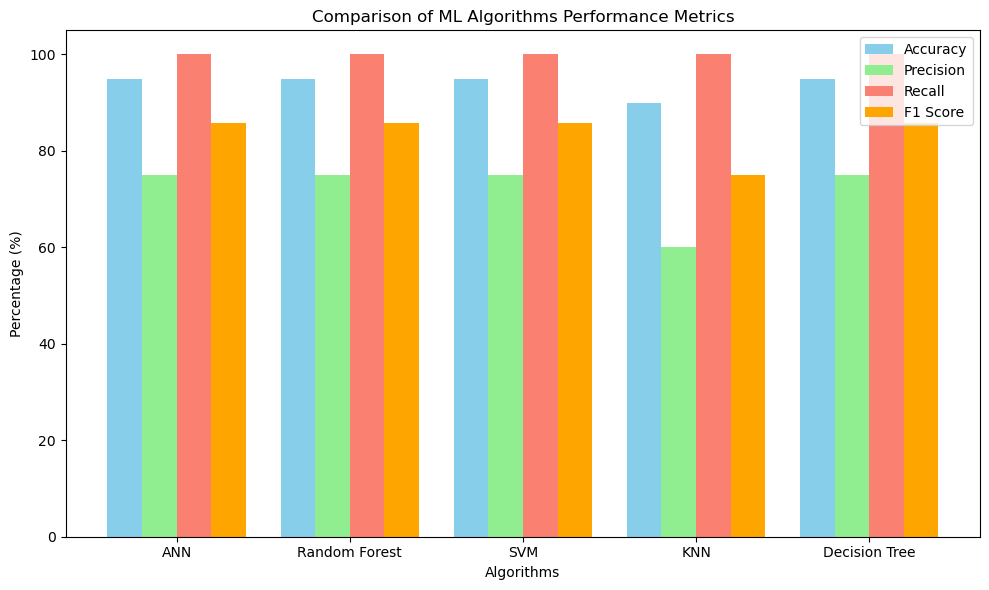

In [191]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for the algorithms
models = ['ANN', 'Random Forest', 'SVM', 'KNN', 'Decision Tree']
accuracy = [95.00, 95.00, 95.00, 90.00, 95.00]
precision = [75.00, 75.00, 75.00, 60.00, 75.00]
recall = [100.00, 100.00, 100.00, 100.00, 100.00]
f1_score = [85.71, 85.71, 85.71, 75.00, 85.71]

# Create an array for bar positions
x = np.arange(len(models))

# Set width of the bars
width = 0.2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width*1.5, accuracy, width, label='Accuracy', color='skyblue')
ax.bar(x - width/2, precision, width, label='Precision', color='lightgreen')
ax.bar(x + width/2, recall, width, label='Recall', color='salmon')
ax.bar(x + width*1.5, f1_score, width, label='F1 Score', color='orange')

# Add labels, title, and ticks
ax.set_xlabel('Algorithms')
ax.set_ylabel('Percentage (%)')
ax.set_title('Comparison of ML Algorithms Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [192]:
plt.savefig('/kaggle/working/plot.png', format='png')


<Figure size 640x480 with 0 Axes>

In [193]:
from scipy.special import expit  # Sigmoid function

# Calculate probabilities
probas = {
    'ANN': b3_ann.predict_proba(current_season)[:, 1],
    'RF': b3_rf.predict_proba(current_season)[:, 1],
    'SVM': b3_svm.decision_function(current_season),  # Use decision_function as an alternative
    'KNN': b3_knn.predict_proba(current_season)[:, 1],
    'DT': b3_dt.predict_proba(current_season)[:, 1]
}

# Convert decision_function to probabilities for SVM
probas['SVM'] = expit(probas['SVM'])

# Average the probabilities
avg_pred_b3 = (probas['ANN'] + 
               probas['RF'] +
               probas['SVM'] + 
               probas['KNN'] +
               probas['DT']) / 5

# Display the average predictions
avg_pred_b3


1/1 [==============================] - 0s 39ms/step


array([4.39660594e-12, 7.59453534e-12, 2.21221323e-10, 1.06813251e-07,
       2.33947089e-07, 1.05725426e-06, 6.47642030e-06, 2.98817626e-06,
       2.94338571e-01, 6.13201227e-04, 1.14094397e-03, 1.31479142e-03,
       1.62697195e-03, 2.83406654e-03, 1.31328363e-02, 9.79745968e-02,
       7.70705517e-01, 9.94549874e-01, 9.99249558e-01, 9.99976787e-01])

In [194]:
import pandas as pd

# Assuming avg_pred_b3 is defined and you want to use it
df_results = pd.concat([
    teams,
    pd.Series(avg_pred_b3, name='ensemble_result'),
    pd.Series(y_test_b3, name='Bottom 3')
], axis=1)

print(df_results)


    Pos                     Team  ensemble_result  Bottom 3
0     1          Manchester City     4.396606e-12         0
1     2                  Arsenal     7.594535e-12         0
2     3                Liverpool     2.212213e-10         0
3     4              Aston Villa     1.068133e-07         0
4     5        Tottenham Hotspur     2.339471e-07         0
5     6                  Chelsea     1.057254e-06         0
6     7         Newcastle United     6.476420e-06         0
7     8        Manchester United     2.988176e-06         0
8     9          West Ham United     2.943386e-01         0
9    10           Crystal Palace     6.132012e-04         0
10   11   Brighton & Hove Albion     1.140944e-03         0
11   12          AFC Bournemouth     1.314791e-03         0
12   13                   Fulham     1.626972e-03         0
13   14  Wolverhampton Wanderers     2.834067e-03         0
14   15             Everton (-8)     1.313284e-02         0
15   16                Brentford     9.7

# **Final Result**

In [195]:
final_table = pd.concat([teams,pd.Series(current_season['Pts'], name='Points'),pd.Series(avg_pred_t4, name='t4_ensemble_result'),pd.Series(y_test_t4, name='Top 4'),
          pd.Series(avg_pred_b3, name='b3_ensemble_result'),pd.Series(y_test_b3, name='Bottom 3')], axis=1)

def highlight(s):
    if s['t4_ensemble_result'] > 0:
        return ['background-color: green'] * len(s)
    if s['b3_ensemble_result'] >= 0.8:
        return ['background-color: red'] * len(s)
    if s['b3_ensemble_result'] > 0:
        return ['background-color: orange'] * len(s)

    
final_table = final_table.style.apply(highlight, axis=1)
final_table

,Pos,Team,Points,t4_ensemble_result,Top 4,b3_ensemble_result,Bottom 3
0,1,Manchester City,91,0.999944,1,0.000000,0
1,2,Arsenal,89,0.999936,1,0.000000,0
2,3,Liverpool,82,0.999514,1,0.000000,0
3,4,Aston Villa,68,0.306914,1,0.000000,0
4,5,Tottenham Hotspur,66,0.410855,0,0.000000,0
5,6,Chelsea,63,0.060799,0,0.000001,0
6,7,Newcastle United,60,0.083329,0,0.000006,0
7,8,Manchester United,60,0.000860,0,0.000003,0
8,9,West Ham United,52,0.000012,0,0.294339,0
9,10,Crystal Palace,49,0.000039,0,0.000613,0


The models predicts most of the current top four and bottom three teams to remain the same by the end of the season (Liverpool is given higher probability than Manchester United, for top 4, while Everton is given a higher probability than ). Of course, a lot can change with about 7 matches left in the season. The model for predicting the bottom three also shows that every team from the 11th place (where Chelsea currently is) is still in danger of ending up in the bottom three.

## **Closing**

In [196]:
#create dataframe for current season; edited csv from https://www.footballwebpages.co.uk/premier-league/league-table to match other dataframes
current_season_df = pd.read_csv('/kaggle/input/ghsoccer/GFANow.csv')
current_season_df.index += 1

current_season_df

,Season,Pos,Team,Pld,W,D,L,F,A,GD,Pts
1,2023-24,1,Samartex,34,19,4,11,45,28,17,61
2,2023-24,2,Accra Lions,34,14,9,11,37,36,1,51
3,2023-24,3,Berekum Chelsea,34,15,6,13,37,41,-4,51
4,2023-24,4,Nsoatreman,34,14,8,12,33,29,4,50
5,2023-24,5,Aduana Stars,34,16,2,16,43,36,7,50
6,2023-24,6,Asante Kotoko,34,14,7,13,35,29,6,49
7,2023-24,7,Nations,34,14,7,13,32,28,4,49
8,2023-24,8,Medeama,34,14,7,13,27,26,1,49
9,2023-24,9,Dreams FC,34,13,9,12,44,35,9,48
10,2023-24,10,Bechem United,34,12,12,10,41,34,7,48


In [197]:
current_season = current_season_df.copy()
current_season = current_season.reset_index(drop=True)
current_season['Top 4'] = 0
current_season['Bottom 3'] = 0

current_season.loc[current_season['Pos'] <= 4, 'Top 4'] = 1
current_season.loc[current_season['Pos'] >= 18, 'Bottom 3'] = 1

y_test_t4 = current_season['Top 4'].copy()
y_test_b3 = current_season['Bottom 3'].copy()

teams = current_season[['Pos','Team']].copy()

In [198]:
current_season = current_season.drop(columns=['Season','Pld','Pos','Team','Top 4', 'Bottom 3'])
current_season

,W,D,L,F,A,GD,Pts
0,19,4,11,45,28,17,61
1,14,9,11,37,36,1,51
2,15,6,13,37,41,-4,51
3,14,8,12,33,29,4,50
4,16,2,16,43,36,7,50
5,14,7,13,35,29,6,49
6,14,7,13,32,28,4,49
7,14,7,13,27,26,1,49
8,13,9,12,44,35,9,48
9,12,12,10,41,34,7,48


In [199]:
y_test_t4

0     1
1     1
2     1
3     1
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
Name: Top 4, dtype: int64

In [200]:
y_test_b3

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    1
Name: Bottom 3, dtype: int64

In [201]:
# Accuracy
print((f't4_ann: {round(accuracy_score(y_test_t4, t4_ann.predict(current_season)) * 100, 2)}% \n'
       f't4_rf: {round(accuracy_score(y_test_t4, t4_rf.predict(current_season)) * 100, 2)}% \n'
       f't4_svm: {round(accuracy_score(y_test_t4, t4_svm.predict(current_season)) * 100, 2)}% \n'
       f't4_knn: {round(accuracy_score(y_test_t4, t4_knn.predict(current_season)) * 100, 2)}% \n'
       f't4_dt: {round(accuracy_score(y_test_t4, t4_dt.predict(current_season)) * 100, 2)}%'))

# Precision
print((f't4_ann: {round(precision_score(y_test_t4, t4_ann.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_rf: {round(precision_score(y_test_t4, t4_rf.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_svm: {round(precision_score(y_test_t4, t4_svm.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_knn: {round(precision_score(y_test_t4, t4_knn.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_dt: {round(precision_score(y_test_t4, t4_dt.predict(current_season), average="binary") * 100, 2)}%'))

# Recall
print((f't4_ann: {round(recall_score(y_test_t4, t4_ann.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_rf: {round(recall_score(y_test_t4, t4_rf.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_svm: {round(recall_score(y_test_t4, t4_svm.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_knn: {round(recall_score(y_test_t4, t4_knn.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_dt: {round(recall_score(y_test_t4, t4_dt.predict(current_season), average="binary") * 100, 2)}%'))

# F1 Score
print((f't4_ann: {round(f1_score(y_test_t4, t4_ann.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_rf: {round(f1_score(y_test_t4, t4_rf.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_svm: {round(f1_score(y_test_t4, t4_svm.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_knn: {round(f1_score(y_test_t4, t4_knn.predict(current_season), average="binary") * 100, 2)}% \n'
       f't4_dt: {round(f1_score(y_test_t4, t4_dt.predict(current_season), average="binary") * 100, 2)}%'))


1/1 [==============================] - 0s 37ms/step
t4_ann: 83.33% 
t4_rf: 77.78% 
t4_svm: 77.78% 
t4_knn: 77.78% 
t4_dt: 77.78%
1/1 [==============================] - 0s 30ms/step
t4_ann: 100.0% 
t4_rf: 0.0% 
t4_svm: 0.0% 
t4_knn: 0.0% 
t4_dt: 0.0%


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- A
- F
Feature names seen at fit time, yet now missing:
- GA
- GF

  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- A
- F
Feature names seen at fit time, yet now missing:
- GA
- GF

  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- A
- F
Feature names seen at fit time, yet now missing:
- GA
- GF

  warnings.warn(message, FutureWarning)
/opt/conda

1/1 [==============================] - 0s 29ms/step
t4_ann: 25.0% 
t4_rf: 0.0% 
t4_svm: 0.0% 
t4_knn: 0.0% 
t4_dt: 0.0%
1/1 [==============================] - 0s 25ms/step


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- A
- F
Feature names seen at fit time, yet now missing:
- GA
- GF

  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- A
- F
Feature names seen at fit time, yet now missing:
- GA
- GF

  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- A
- F
Feature names seen at fit time, yet now missing:
- GA
- GF

  warnings.warn(message, FutureWarning)
/opt/conda

TypeError: 'list' object is not callable

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for the algorithms
models = ['ANN', 'Random Forest', 'SVM', 'KNN', 'Decision Tree']
accuracy = [95.00, 95.00, 95.00, 90.00, 95.00]
precision = [100.00, 80.00, 100.00, 75.00, 100.00]
recall = [75.00, 100.00, 75.00, 75.00, 75.00]
f1_score = [85.71, 88.89, 85.71, 75.00, 85.71]

# Create an array for bar positions
x = np.arange(len(models))

# Set width of the bars
width = 0.2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width*1.5, accuracy, width, label='Accuracy', color='skyblue')
ax.bar(x - width/2, precision, width, label='Precision', color='lightgreen')
ax.bar(x + width/2, recall, width, label='Recall', color='salmon')
ax.bar(x + width*1.5, f1_score, width, label='F1 Score', color='orange')

# Add labels, title, and ticks
ax.set_xlabel('Algorithms')
ax.set_ylabel('Percentage (%)')
ax.set_title('Comparison of ML Algorithms Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [202]:
# Calculate average prediction only for models that support predict_proba
probas = {
    'ANN': t4_ann.predict_proba(current_season)[:, 1],
    'RF': t4_rf.predict_proba(current_season)[:, 1],
    'SVM': t4_svm.decision_function(current_season),  # Use decision_function as an alternative
    'KNN': t4_knn.predict_proba(current_season)[:, 1],
    'DT': t4_dt.predict_proba(current_season)[:, 1]
}

# Convert decision_function to probabilities for SVM (use sigmoid function if needed)
from scipy.special import expit  # Sigmoid function
probas['SVM'] = expit(probas['SVM'])

# Average the probabilities
avg_pred_t4 = (probas['ANN'] + 
               probas['RF'] +
               probas['SVM'] + 
               probas['KNN'] +
               probas['DT']) / 5
avg_pred_t4


1/1 [==============================] - 0s 26ms/step


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- A
- F
Feature names seen at fit time, yet now missing:
- GA
- GF

  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- A
- F
Feature names seen at fit time, yet now missing:
- GA
- GF

  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- A
- F
Feature names seen at fit time, yet now missing:
- GA
- GF

  warnings.warn(message, FutureWarning)
/opt/conda

array([1.37217873e-01, 2.43244013e-03, 1.70724653e-04, 1.23793852e-03,
       5.11308397e-03, 1.77378972e-03, 3.27379534e-03, 2.80490074e-03,
       3.29570711e-03, 6.15562810e-04, 1.15422277e-04, 2.37368767e-05,
       2.29168338e-05, 2.33220805e-04, 3.32802486e-04, 2.13268564e-03,
       2.00070672e-03, 1.96415380e-08])

In [203]:
import pandas as pd

# Assuming avg_pred_t4 is defined and you want to use it
df_results = pd.concat([
    teams,
    pd.Series(avg_pred_t4, name='ensemble_result'),
    pd.Series(y_test_t4, name='Top 4')
], axis=1)

print(df_results.head())


   Pos             Team  ensemble_result  Top 4
0    1         Samartex         0.137218      1
1    2      Accra Lions         0.002432      1
2    3  Berekum Chelsea         0.000171      1
3    4       Nsoatreman         0.001238      1
4    5     Aduana Stars         0.005113      0


In [204]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming the following predictions and true values:
# y_test_b3 is your true labels
# b3_ann, b3_rf, b3_svm, b3_knn, b3_dt are your models

# Accuracy
print((f'b3_ann: {round(accuracy_score(y_test_b3, b3_ann.predict(current_season)) * 100, 2)}% \n'
       f'b3_rf: {round(accuracy_score(y_test_b3, b3_rf.predict(current_season)) * 100, 2)}% \n'
       f'b3_svm: {round(accuracy_score(y_test_b3, b3_svm.predict(current_season)) * 100, 2)}% \n'
       f'b3_knn: {round(accuracy_score(y_test_b3, b3_knn.predict(current_season)) * 100, 2)}% \n'
       f'b3_dt: {round(accuracy_score(y_test_b3, b3_dt.predict(current_season)) * 100, 2)}%'))

# Precision
print((f'b3_ann: {round(precision_score(y_test_b3, b3_ann.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_rf: {round(precision_score(y_test_b3, b3_rf.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_svm: {round(precision_score(y_test_b3, b3_svm.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_knn: {round(precision_score(y_test_b3, b3_knn.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_dt: {round(precision_score(y_test_b3, b3_dt.predict(current_season), average="binary") * 100, 2)}%'))

# Recall
print((f'b3_ann: {round(recall_score(y_test_b3, b3_ann.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_rf: {round(recall_score(y_test_b3, b3_rf.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_svm: {round(recall_score(y_test_b3, b3_svm.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_knn: {round(recall_score(y_test_b3, b3_knn.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_dt: {round(recall_score(y_test_b3, b3_dt.predict(current_season), average="binary") * 100, 2)}%'))

# F1 Score
print((f'b3_ann: {round(f1_score(y_test_b3, b3_ann.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_rf: {round(f1_score(y_test_b3, b3_rf.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_svm: {round(f1_score(y_test_b3, b3_svm.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_knn: {round(f1_score(y_test_b3, b3_knn.predict(current_season), average="binary") * 100, 2)}% \n'
       f'b3_dt: {round(f1_score(y_test_b3, b3_dt.predict(current_season), average="binary") * 100, 2)}%'))


1/1 [==============================] - 0s 33ms/step
b3_ann: 100.0% 
b3_rf: 94.44% 
b3_svm: 94.44% 
b3_knn: 100.0% 
b3_dt: 100.0%
1/1 [==============================] - 0s 26ms/step
b3_ann: 100.0% 
b3_rf: 50.0% 
b3_svm: 50.0% 
b3_knn: 100.0% 
b3_dt: 100.0%
1/1 [==============================] - 0s 26ms/step


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- A
- F
Feature names seen at fit time, yet now missing:
- GA
- GF

  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- A
- F
Feature names seen at fit time, yet now missing:
- GA
- GF

  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- A
- F
Feature names seen at fit time, yet now missing:
- GA
- GF

  warnings.warn(message, FutureWarning)
/opt/conda

b3_ann: 100.0% 
b3_rf: 100.0% 
b3_svm: 100.0% 
b3_knn: 100.0% 
b3_dt: 100.0%
1/1 [==============================] - 0s 26ms/step
b3_ann: 100.0% 
b3_rf: 66.67% 
b3_svm: 66.67% 
b3_knn: 100.0% 
b3_dt: 100.0%


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- A
- F
Feature names seen at fit time, yet now missing:
- GA
- GF

  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- A
- F
Feature names seen at fit time, yet now missing:
- GA
- GF

  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- A
- F
Feature names seen at fit time, yet now missing:
- GA
- GF

  warnings.warn(message, FutureWarning)
/opt/conda

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for the algorithms
models = ['ANN', 'Random Forest', 'SVM', 'KNN', 'Decision Tree']
accuracy = [95.00, 95.00, 95.00, 90.00, 95.00]
precision = [75.00, 75.00, 75.00, 60.00, 75.00]
recall = [100.00, 100.00, 100.00, 100.00, 100.00]
f1_score = [85.71, 85.71, 85.71, 75.00, 85.71]

# Create an array for bar positions
x = np.arange(len(models))

# Set width of the bars
width = 0.2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width*1.5, accuracy, width, label='Accuracy', color='skyblue')
ax.bar(x - width/2, precision, width, label='Precision', color='lightgreen')
ax.bar(x + width/2, recall, width, label='Recall', color='salmon')
ax.bar(x + width*1.5, f1_score, width, label='F1 Score', color='orange')

# Add labels, title, and ticks
ax.set_xlabel('Algorithms')
ax.set_ylabel('Percentage (%)')
ax.set_title('Comparison of ML Algorithms Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [205]:
from scipy.special import expit  # Sigmoid function

# Calculate probabilities
probas = {
    'ANN': b3_ann.predict_proba(current_season)[:, 1],
    'RF': b3_rf.predict_proba(current_season)[:, 1],
    'SVM': b3_svm.decision_function(current_season),  # Use decision_function as an alternative
    'KNN': b3_knn.predict_proba(current_season)[:, 1],
    'DT': b3_dt.predict_proba(current_season)[:, 1]
}

# Convert decision_function to probabilities for SVM
probas['SVM'] = expit(probas['SVM'])

# Average the probabilities
avg_pred_b3 = (probas['ANN'] + 
               probas['RF'] +
               probas['SVM'] + 
               probas['KNN'] +
               probas['DT']) / 5

# Display the average predictions
avg_pred_b3


1/1 [==============================] - 0s 27ms/step


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- A
- F
Feature names seen at fit time, yet now missing:
- GA
- GF

  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- A
- F
Feature names seen at fit time, yet now missing:
- GA
- GF

  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- A
- F
Feature names seen at fit time, yet now missing:
- GA
- GF

  warnings.warn(message, FutureWarning)
/opt/conda

array([5.33104903e-07, 5.52368228e-05, 5.69221050e-05, 7.16034886e-05,
       9.60129771e-05, 1.21097075e-04, 1.01092783e-02, 8.09554600e-03,
       3.07826638e-04, 2.80054967e-04, 4.73298794e-04, 6.49729617e-04,
       8.76902995e-03, 1.00076733e-03, 9.51902336e-04, 7.16402144e-03,
       3.31734870e-01, 8.91628475e-01])

In [206]:
import pandas as pd

# Assuming avg_pred_b3 is defined and you want to use it
df_results = pd.concat([
    teams,
    pd.Series(avg_pred_b3, name='ensemble_result'),
    pd.Series(y_test_b3, name='Bottom 3')
], axis=1)

print(df_results)

    Pos                Team  ensemble_result  Bottom 3
0     1            Samartex     5.331049e-07         0
1     2         Accra Lions     5.523682e-05         0
2     3     Berekum Chelsea     5.692211e-05         0
3     4          Nsoatreman     7.160349e-05         0
4     5        Aduana Stars     9.601298e-05         0
5     6       Asante Kotoko     1.210971e-04         0
6     7            Nations      1.010928e-02         0
7     8             Medeama     8.095546e-03         0
8     9           Dreams FC     3.078266e-04         0
9    10       Bechem United     2.800550e-04         0
10   11  Bibiani Gold Stars     4.732988e-04         0
11   12              Karela     6.497296e-04         0
12   13        Legon Cities     8.769030e-03         0
13   14       Hearts of Oak     1.000767e-03         0
14   15      Heart of Lions     9.519023e-04         0
15   16      Great Olympics     7.164021e-03         0
16   17       Bofoakwe Tano     3.317349e-01         0
17   18   

In [207]:
final_table = pd.concat([teams,pd.Series(current_season['Pts'], name='Points'),pd.Series(avg_pred_t4, name='t4_ensemble_result'),pd.Series(y_test_t4, name='Top 4'),
          pd.Series(avg_pred_b3, name='b3_ensemble_result'),pd.Series(y_test_b3, name='Bottom 3')], axis=1)

def highlight(s):
    if s['t4_ensemble_result'] > 0:
        return ['background-color: green'] * len(s)
    if s['b3_ensemble_result'] >= 0.8:
        return ['background-color: red'] * len(s)
    if s['b3_ensemble_result'] > 0:
        return ['background-color: orange'] * len(s)

    
final_table = final_table.style.apply(highlight, axis=1)
final_table

,Pos,Team,Points,t4_ensemble_result,Top 4,b3_ensemble_result,Bottom 3
0,1,Samartex,61,0.137218,1,0.000001,0
1,2,Accra Lions,51,0.002432,1,0.000055,0
2,3,Berekum Chelsea,51,0.000171,1,0.000057,0
3,4,Nsoatreman,50,0.001238,1,0.000072,0
4,5,Aduana Stars,50,0.005113,0,0.000096,0
5,6,Asante Kotoko,49,0.001774,0,0.000121,0
6,7,Nations,49,0.003274,0,0.010109,0
7,8,Medeama,49,0.002805,0,0.008096,0
8,9,Dreams FC,48,0.003296,0,0.000308,0
9,10,Bechem United,48,0.000616,0,0.000280,0
